In [18]:
package = ['boto3','es_lemmatizer','pyodbc','prince']
f= open("paquetes.txt","w+")

def install_txt(package):
  f= open("paquetes.txt","w+")
  for i in package:
    print(i)
    

    try:
        __import__(i)
        print('ya instalado {}'.format(i))
    except ImportError:
        # main(['install', package]) 
        f.write("{} \r\n".format(i))
        print('No instalado {}'.format(i))


install_txt(package)  

boto3
ya instalado boto3
es_lemmatizer
ya instalado es_lemmatizer
pyodbc
ya instalado pyodbc
prince
ya instalado prince


In [19]:
!pip install -r paquetes.txt

#**Librerias**

In [20]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Rutas**

In [21]:
#RUTAS
#OF :Operaciones financieras
#P : Personal

# Campaña_OF = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCF - Cuentas por pagar.xlsx')
# Campaña_P = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCP - Beneficio Educativo.xlsx')


In [22]:
#Rutas en Drive colab
os.getcwd()

'/content'

In [23]:
Campaña_OF =  "/content/Modelo Analítico PCF - Cuentas por pagar.xlsx"
Campaña_P  = "/content/Modelo Analítico PCP - Beneficio Educativo.xlsx"

#**Funciones**

In [24]:
# CONEXION A SERVIDOR ###################################################################################
# def Conexion():
#     server = '172.27.48.148'
#     #database = 'bdcmp_NuevaEpsCrm' 
#     username = 'CienciaDatos' 
#     password = 'C13nc1aD47*5'  
#     cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
#     cursor = cnxn.cursor()
#     return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_OF):
    df_OF = df_Tipo_OF.astype(str).replace('NaT','20200101')
#######Operaciones financieras
    df_OF ['fecha_ini_1'] = df_OF['Picos de demanda  1'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_1'] = ['20210401','20210301','20210301','20210301', '20210301', '20210301', '20210401']
    df_OF ['fecha_ini_2'] = df_OF['Picos de demanda  2'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_2'] = ['20210501', '20210501', '20200101', '20210501', '20200101', '20210501', '20201001']
    df_OF ['fecha_ini_3'] = df_OF['Picos de demanda  3'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_3'] = ['20210601', '20200101', '20200101', '20210601', '20200101', '20200101', '20210101']
    
    return df_OF  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice] "
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop
# columnas duplicadas
def columnas_dup(df):
    df_dup = df.T.duplicated().T
    return df_dup
#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

def mytable(data):
    nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns=['% de datos nulos'])
    ceros = pd.DataFrame((data==0).sum()/data.shape[0]*100, columns=['% de ceros'])
    tipo = pd.DataFrame(data.dtypes,columns=['Tipo de datos'])
    val = pd.DataFrame(data.nunique(),columns=['# de valores diferentes'])
    valpor = pd.DataFrame(data.nunique()/data.shape[0]*100,columns=['% de valores diferentes'])
    mis_val_table = pd.concat([nulls, ceros,tipo, val, valpor], axis=1)
    return mis_val_table

**CAMPAÑA OPERACIONES FINACIERAS - CUENTAS POR PAGAR**

# **EXTRACCIÓN**

## **Definición de Tipologías y meses que se extraeran**

Se extrae tabla producto del entendimiento del negocio donde se encuentran definidas las tipologias y meses donde se presentaron los picos a estudiar

In [25]:
df_Tipo_OF =  pd.read_excel(Campaña_OF, sheet_name = '2. Esquema Tipologías de Servic', usecols = "B:H", skiprows= lambda x: x in [0, 1]).astype(str).replace('NaT','0') 

-- Campaña Operaciones financieras

In [26]:
df_Tipo_OF

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01


Se definen fechas de los picos en cada tipologia con el fin de realizar el posterior filtro 

In [27]:
df_fechas_OF = fechas(df_Tipo_OF)

In [28]:
df_fechas_OF

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3,fecha_ini_1,fecha_fin_1,fecha_ini_2,fecha_fin_2,fecha_ini_3,fecha_fin_3
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01,20210301,20210401,20210401,20210501,20210501,20210601
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0,20210201,20210301,20210401,20210501,20200101,20200101
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0,20210201,20210301,20200101,20200101,20200101,20200101
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01,20210201,20210301,20210401,20210501,20210501,20210601
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0,20210201,20210301,20200101,20200101,20200101,20200101
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0,20210201,20210301,20210401,20210501,20200101,20200101
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01,20210301,20210401,20200901,20201001,20201201,20210101


## **Pefilamiento inicial OF**

In [29]:
#Lectura
df_Registros_OF = pd.read_csv('Base_registros_extraida_OF.csv')
df_Registros_OF.head(2)

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NombreDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_FechaNacimientoContacto,fgs_HabeasContacto,fgs_NombreGeneroContacto,fgs_RoutingPointOrVdn,fgs_Extension,fgs_CallId,fgs_Skill,fgs_Ani,fgs_Ip,fgs_OpcionesIVR,fgs_FechaInicio,fgs_FechaFin,fgs_IdTipificacionGestionDetalle,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Nivel5,fgs_Nivel6,fgs_Nivel7,fgs_Nivel8,fgs_Nivel9,fgs_Nivel10,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,...,T_Objetivo_Total,T_Real_Total,Cumple_Objetivo_Total,fdp_IdHistoricoPqrGestionActual,fdp_IdGrupoGestionActual,fdp_NombreGrupoGestionActual,fdp_IdDetalleFlujoGestionActual,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,Ajustado,TipoAjuste,Valido,Pruebas,fdp_FechaVencimientoTotal,NoReprocesar,fdp_IdHistoricoPqrEscalamientoN4,fdp_IdGrupoEscalamientoN4,fdp_NombreGrupoEscalamientoN4,fdp_IdDetalleFlujoEscalamientoN4,fdp_IdUsuarioEscalamientoN4,fdp_UsuarioEscalamientoN4,fdp_NombreUsuarioEscalamientoN4,fgs_ObservacionEscalamientoN4,fdp_FechaEscalamientoN4,fdp_FechaVencimientoEscalamientoN4,CodigoGrupoRolEscalamientoN4,GrupoRolEscalamientoN4,fdp_MotivoEscalamientoN4,fdp_NivelEscalamientoN4,T_Objetivo_EnNivel4,T_Real_EnNivel4,Cumple_Objetivo_EnNivel4
0,12,14051976,1111309.0,Operaciones Financieras,Web,NIT,NaN,9003104584,METROOMAT NDT SAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:08:30.000,2021-03-01 06:10:58.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,CR 52 44 A 35,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,147.0,1.026290e+09,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,1.0,Asesor de Servicio Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica
1,12,14052000,1111345.0,Operaciones Financieras,Web,NIT,NaN,9001358397,CGG SERVICES SUCUSAL COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:15:54.000,2021-03-01 06:27:09.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,AV CR 45 108 A 50 P 6,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,103.0,1.012361e+09,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,2021-03-01 06:27:09.000,2020-02-25 16:30:00.000,8.0,Asesor de Servicio BackOffice Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica


In [30]:
tabla=mytable(df_Registros_OF)
display(tabla,df_Registros_OF.shape)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_IdGestion,0.000000,0.000000,int64,11224,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,11224,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,7.733428,92.266572,float64,1,0.008909


(11224, 222)

In [31]:
tabla.describe(percentiles=[.05,0.25,0.5,.75,.95])

,% de datos nulos,% de ceros,# de valores diferentes,% de valores diferentes
count,222.000000,222.000000,222.000000,222.000000
mean,52.248078,4.764525,714.112613,6.362372
std,48.202681,20.593389,2422.086736,21.579533
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,92.489309,0.000000,2.000000,0.017819
75%,100.000000,0.000000,15.750000,0.140324
95%,100.000000,7.623842,8158.000000,72.683535
max,100.000000,100.000000,11224.000000,100.000000


In [32]:
vacios = tabla[tabla['% de datos nulos']==100]
vacios

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_NombreDocumentoContacto,100.0,0.0,float64,0,0.0
fgs_FechaNacimientoContacto,100.0,0.0,float64,0,0.0
fgs_HabeasContacto,100.0,0.0,float64,0,0.0
fgs_NombreGeneroContacto,100.0,0.0,float64,0,0.0
fgs_RoutingPointOrVdn,100.0,0.0,float64,0,0.0
...,...,...,...,...,...
CodigoGrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
GrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_MotivoEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_NivelEscalamientoN4,100.0,0.0,float64,0,0.0


In [33]:
cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
cardinalidad100

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdGestion,0.0,0.0,int64,11224,100.0
fgs_IdGestionDetalle,0.0,0.0,float64,11224,100.0


In [34]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_IdGestion,0.000000,0.000000,int64,11224,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,11224,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,7.733428,92.266572,float64,1,0.008909


In [35]:
cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
cardinalidad1

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
TipoTransacción,0.000000,0.000000,object,1,0.008909
TipoComplejidad,0.000000,0.000000,object,1,0.008909
Funcionalidad,0.000000,0.000000,object,1,0.008909
DependenciaLínea,0.000000,0.000000,object,1,0.008909
AreaServicio,0.000000,0.000000,object,1,0.008909
fdp_IdGrupoCreacion,0.000000,100.000000,int64,1,0.008909
fdp_NombreGrupoCreacion,0.000000,0.000000,object,1,0.008909


In [36]:
(tabla['# de valores diferentes']==1).loc['fgs_Nivel1']

False

In [37]:
tabla.loc['fgs_Nivel1']

% de datos nulos                  0
% de ceros                        0
Tipo de datos                object
# de valores diferentes           2
% de valores diferentes    0.017819
Name: fgs_Nivel1, dtype: object

In [38]:
tabla.loc['fgs_Nivel1']['# de valores diferentes']==1

False

In [39]:
(tabla['# de valores diferentes']==1).loc['fgs_Nivel1']

False

In [40]:
# tabla[tabla['# de valores diferentes']==1].loc['fgs_Nivel1']

In [41]:
# profile = df_Registros_OF.profile_report(title = 'Pandas Profiling Report', correlations={"cramers": {"calculate": False}})
# profile.to_file(output_file = 'Perfilamiento_BaseInicial_CuentasPorPagar.html')

In [42]:
df_Registros_OF = df_Registros_OF[df_Registros_OF['fgs_Nivel1'] != 'Prestador de Servicios de Salud']
# se fue solo un dato y estefania lo borro.

In [43]:
variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
len(variables_eliminar)

105

In [44]:
mapa_columnas = [i not in variables_eliminar for i in df_Registros_OF.columns]  

In [45]:
sum(mapa_columnas)

117

In [46]:
df_Registros_OF.shape

(11223, 222)

In [47]:
105+117

222

In [48]:
nuevas_columnas = df_Registros_OF.columns[mapa_columnas]

In [49]:
df_Registros_OF = df_Registros_OF[nuevas_columnas]

In [50]:
df_Registros_OF.shape

(11223, 117)

In [51]:
tabla = mytable(df_Registros_OF)

In [52]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.000000,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.000000,int64,2105,18.756126
fgs_NombreCompletoContacto,0.000000,0.000000,object,2047,18.239330
fgs_Ip,0.000000,0.000000,object,143,1.274169
fgs_FechaInicio,0.000000,0.000000,object,11208,99.866346
...,...,...,...,...,...
GrupoRolGestionActual,0.017821,0.000000,object,5,0.044551
fdp_NivelGestionActual,0.000000,0.000000,object,2,0.017821
TipoAjuste,37.102379,0.000000,object,3,0.026731
fdp_FechaVencimientoTotal,0.000000,0.000000,object,9177,81.769580


In [53]:
tabla['Tipo de datos'].value_counts()

object     73
float64    35
int64       8
bool        1
Name: Tipo de datos, dtype: int64

In [54]:
df_Registros_OF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11223 entries, 0 to 11223
Columns: 117 entries, fgs_SiglasDocumentoContacto to NoReprocesar
dtypes: bool(1), float64(35), int64(8), object(73)
memory usage: 10.0+ MB


In [55]:
objetos = df_Registros_OF.select_dtypes(['object'])
numeros = df_Registros_OF.select_dtypes(['int64','float64'])

In [56]:
objetos.describe()

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
count,11223,11223,11223,11223,11223,11223,11223,11223,11223,11223,11187,11223,11037,11219,11223,11223,11223,9419,9855,9855,11223,146,282,151,9788,11223,11223,6737,11223,11223,11223,11223,11223,11223,11223,11223,842,833,842,842,839,833,11223,27,27,27,27,27,26,10716,10716,10716,10716,10710,10716,10716,11223,10716,10716,10716,10716,10710,10716,10716,11223,11221,11223,11223,11215,11221,11223,7059,11223
unique,5,2047,143,11208,11218,2,1,1,7,7,1879,140,26,13,1589,2419,3,6,91,25,14,54,75,69,1707,2,7,6125,2,2,12,8635,11218,2,3,2,2,14,838,842,718,3,3,5,24,27,26,2,3,2,16,8173,10711,316,3,2,2,2,16,7873,10711,316,3,2,3,26,8374,11218,741,5,2,3,9177
top,NIT,CLIENTE ANONIMO ECOPETROL,172.27.90.93,2021-05-07 09:49:11.000,2021-04-15 11:45:10.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NAN,"BOGOTA, D.C.",BOGOTA,Colombia,2345000,notiene@notiene.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,Gerencia Administrativa,AB1001,GERENCIA ADMINISTRAT,comercial.industria@co.bureauveritas.com,Puesto de Trabajo,Causación de facturas / Cockpit,2021-02-12 15:02:00.000,Cerrado,Nivel1,ANGIE CATHERINE BLANDON CACERES,CONSULTA DE FACTURAS,2021-05-31 09:34:33.000,Asesor de Servicio BackOffice Contact Center,No Aplica,Cumple,Equipo de Causación,HAROL ESTIVEN SUAREZ BERNAL,Sin Observaciones,2021-03-19 15:12:26.023000,2021-02-22 07:30:00,Asesor solucionador Ecopetrol,No Aplica,ANGIE CATHERINE BLANDON CACERES,No tengo asignada la factura.,2021-03-15 21:07:37.637000,2021-03-15 07:30:00,Asesor de Servicio BackOffice Contact Center,Escalado al responsable de solución equivocado,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-04-13 15:32:05.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-04-13 15:32:05.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-04-15 11:45:10.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...,2021-03-08 09:45:00.000


In [57]:
objetos.describe().T['unique'].astype('int').describe(percentiles=[0.25,0.5,0.75,0.85,0.90,0.95])

count       73.000000
mean      1766.616438
std       3577.958654
min          1.000000
25%          3.000000
50%         16.000000
75%        838.000000
85%       6474.600000
90%       8582.800000
95%      10909.800000
max      11218.000000
Name: unique, dtype: float64

In [58]:
objetos['fgs_Nivel1'].value_counts()

Cuentas por pagar    11223
Name: fgs_Nivel1, dtype: int64

NIT    10828
CC       392
RC         1
CU         1
TI         1
Name: fgs_SiglasDocumentoContacto, dtype: int64

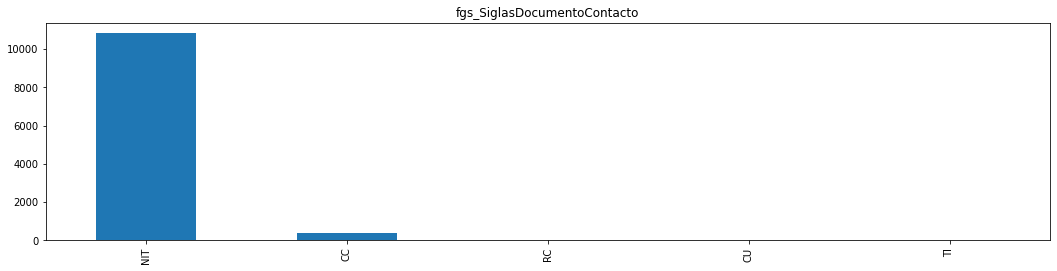

Contacto    10381
Atención      842
Name: fgs_Tipificación, dtype: int64

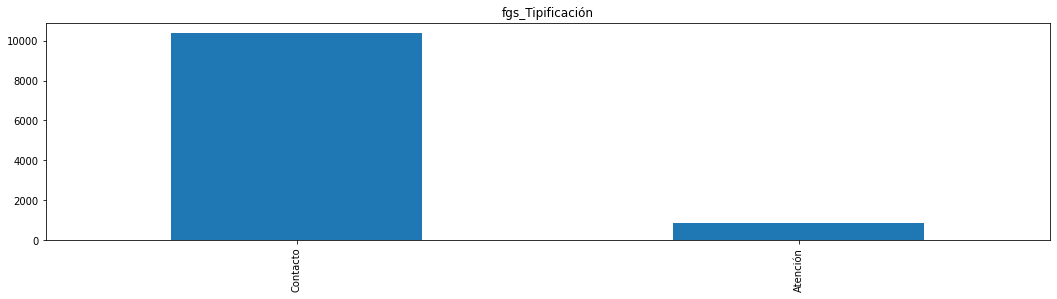

Cuentas por pagar    11223
Name: fgs_Nivel1, dtype: int64

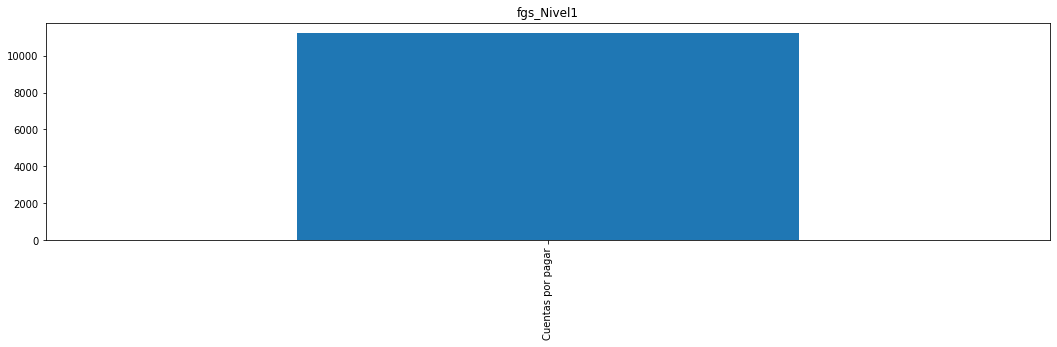

Recepción y contabilización facturas de proveedores    11223
Name: fgs_Nivel2, dtype: int64

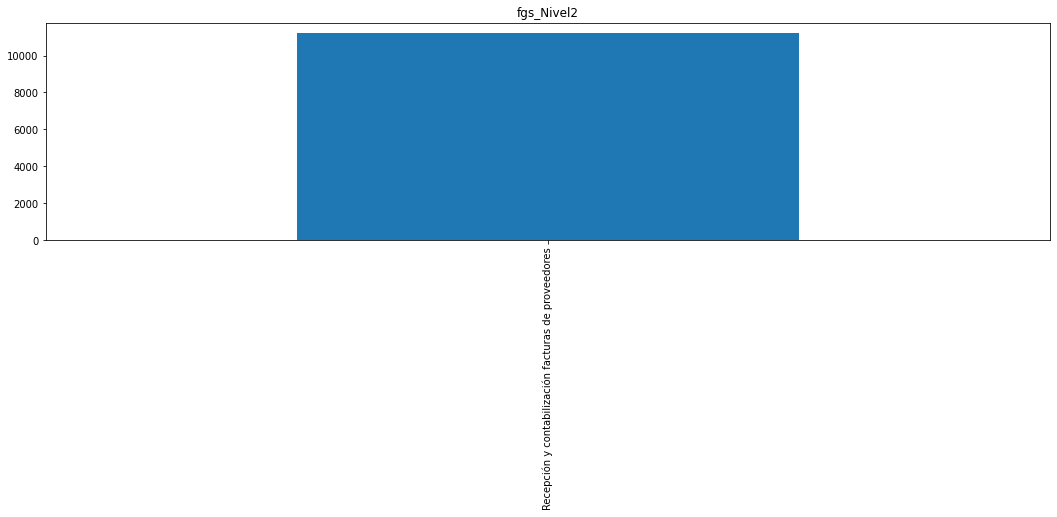

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel3, dtype: int64

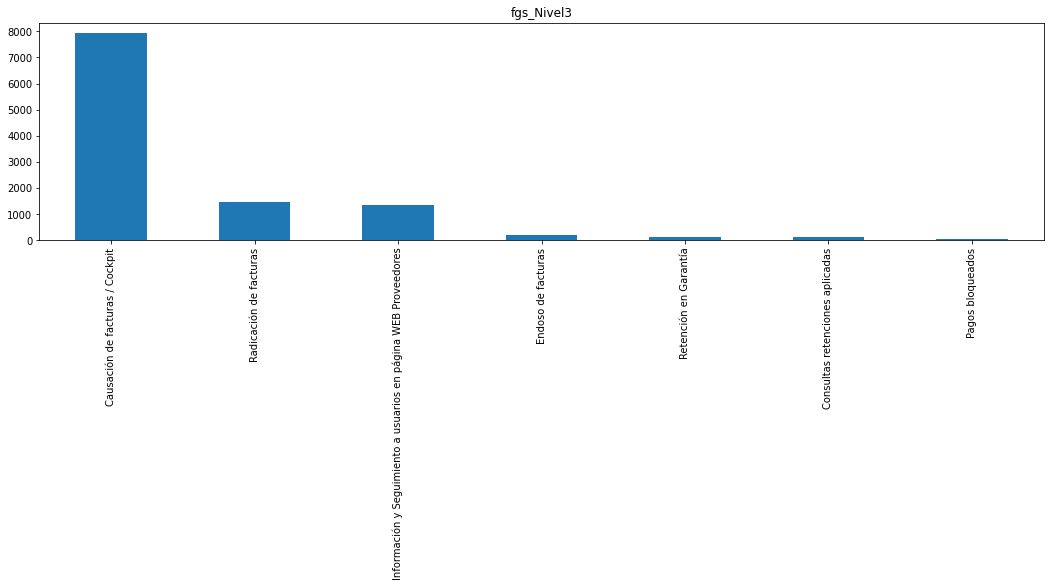

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel4, dtype: int64

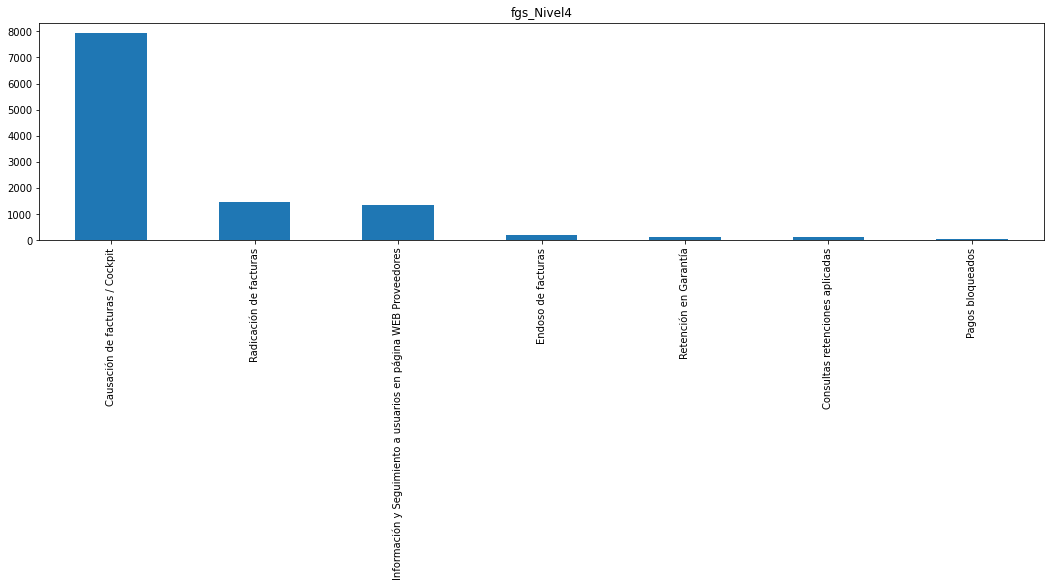

BOGOTA             6765
SANTANDER          1086
ANTIOQUIA           420
META                399
CUNDINAMARCA        372
BOLIVAR             344
HUILA               291
PUTUMAYO            284
VALLE DEL CAUCA     252
ATLANTICO           226
N. DE SANTANDER     182
CASANARE            182
SUCRE                37
BOYACA               34
TOLIMA               31
MAGDALENA            24
NARIÑO               23
CESAR                20
CORDOBA              16
CALDAS               14
RISARALDA            13
QUINDIO              10
ARAUCA                9
CHOCO                 1
GUAVIARE              1
CAUCA                 1
Name: fgs_DepartamentoDireccion_01, dtype: int64

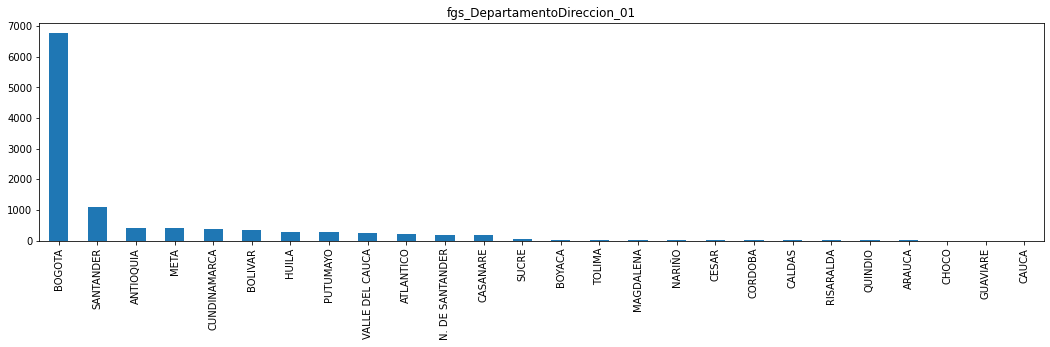

Colombia                     11037
Estados Unidos de América      127
Italia                          16
Brasil                           9
Países Bajos                     8
Francia                          4
México                           4
Reino Unido                      3
Georgia                          3
Noruega                          3
Canadá                           2
Australia                        2
Perú                             1
Name: fgs_PaisDireccion_01, dtype: int64

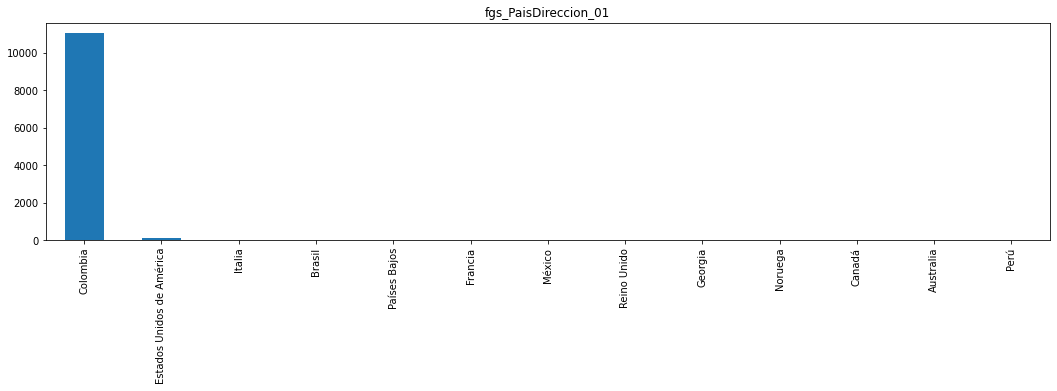

Email BackOffice     6737
Telefónico           4458
Gestión Operativa      28
Name: fmf_Canal, dtype: int64

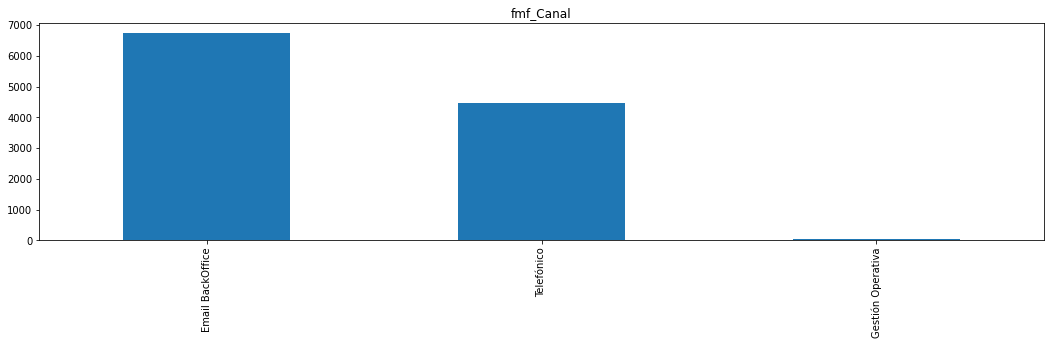

CENTRO ORIENTE       6390
LLANOS ORIENTALES     687
MAGDALENA MEDIO       670
SUR                   621
OCCIDENTE             620
NORTE                 431
Name: ude_Regional, dtype: int64

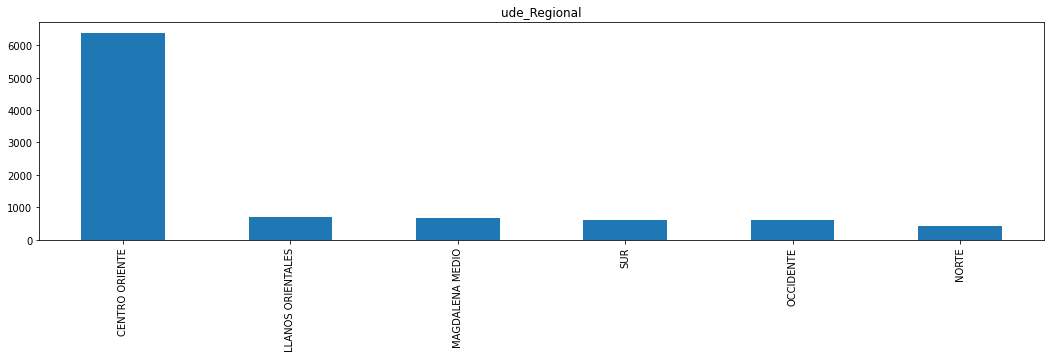

BOGOTA, D.C.       5269
BARRANCABERMEJA     543
BUCARAMANGA         431
CARTAGENA           382
MEDELLIN            285
                   ... 
HONDA                 1
FUSAGASUGA            1
CUMARAL               1
MELGAR                1
POPAYAN               1
Name: ude_CiudadCliente, Length: 91, dtype: int64

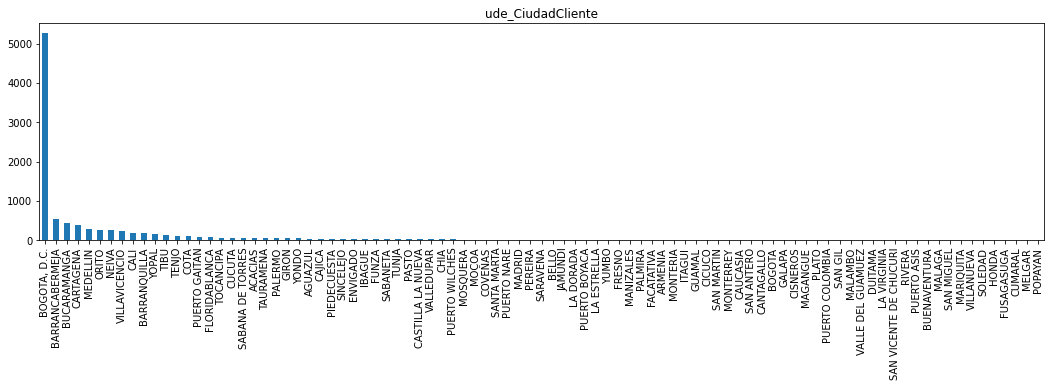

BOGOTA             5273
SANTANDER          1231
ANTIOQUIA           429
META                428
CUNDINAMARCA        401
BOLIVAR             394
HUILA               313
PUTUMAYO            282
CASANARE            257
VALLE DEL CAUCA     220
ATLANTICO           206
N. DE SANTANDER     186
SUCRE                49
TOLIMA               38
BOYACA               31
NARIÑO               22
CESAR                21
MAGDALENA            16
CALDAS               15
RISARALDA            13
ARAUCA               11
CORDOBA              11
QUINDIO               6
CAUCA                 1
LA GUAJIRA            1
Name: ude_DepartamentoCliente, dtype: int64

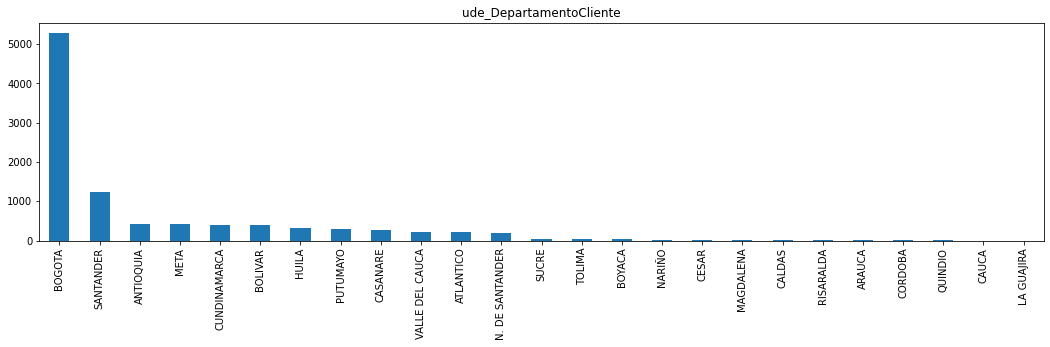

COLOMBIA                     9855
Colombia                     1186
Estados Unidos de América     127
Italia                         16
Brasil                          9
Países Bajos                    8
Francia                         4
México                          4
Reino Unido                     3
Georgia                         3
Noruega                         3
Canadá                          2
Australia                       2
Perú                            1
Name: ude_PaisCliente, dtype: int64

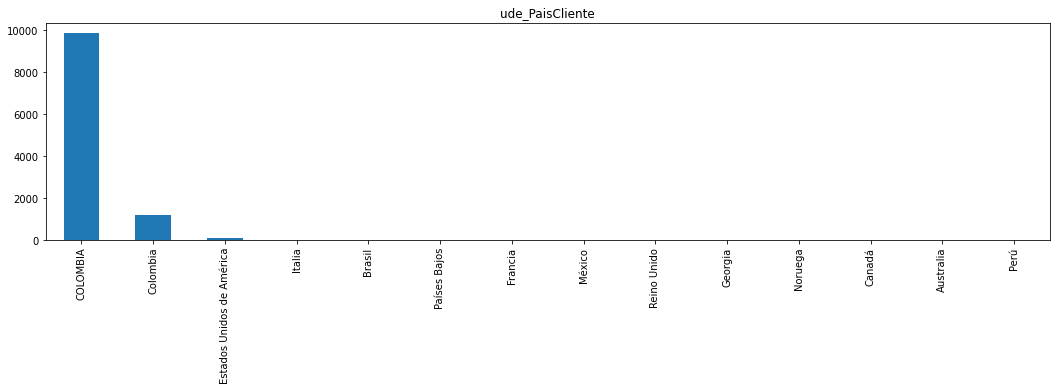

Gerencia Administrativa                     18
Coordinación de Gestión de Contratación     12
Coordinación de Gestión de Cuentas Pagar    12
Coord de Gest de Contrat Reg Andina Orie    10
Gerencia Administrativa VDS                 10
Coord Gestión de Contrat Reg Orinoquía       6
Departamento Regional de HSE Sur             5
Coord de Gestión de Contratación             4
Gerencia de Soporte Tecnológico              4
Gerencia Administrativa VAB                  4
Dep de Gestión Integral y Abastecimiento     4
Depto de Logística, Compras                  3
Coord de Gestión de Contrat Reg Central      3
Gerencia de Seguridad Física                 3
Coordinación Salud Bogotá                    2
Coordinación de Logística de Bienes          2
Coordinación de Operación Tributaria         2
Coordinación de Gestión de Inventarios       2
Gerencia de Planeación de TH                 2
Depto Regional de Abastecimiento Caribe      2
Coordinación Conectividad                    2
Gerencia de D

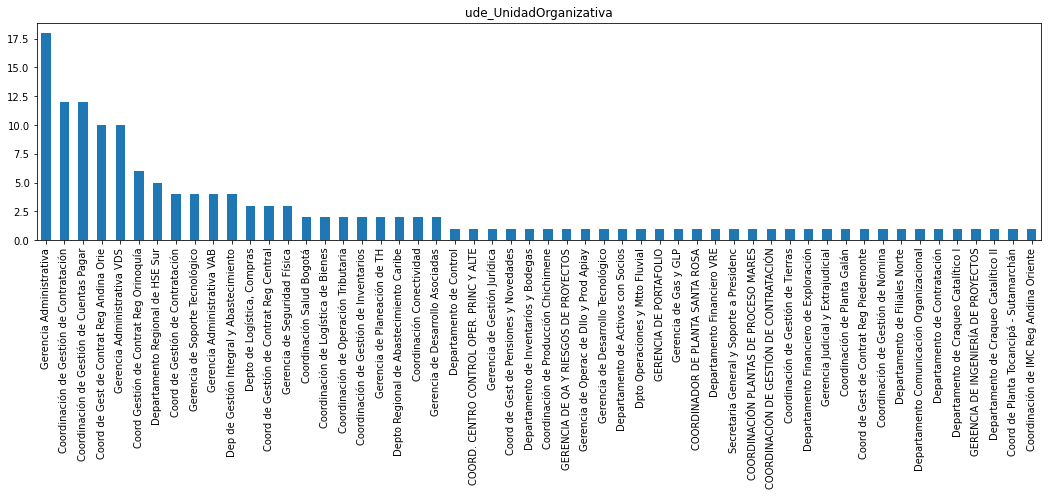

AB1001    40
AB0001    39
PY0012    22
SO0068    15
SC5107    12
          ..
SC2108     1
PR7852     1
SO0072     1
CO0139     1
PY0010     1
Name: ude_CECO, Length: 75, dtype: int64

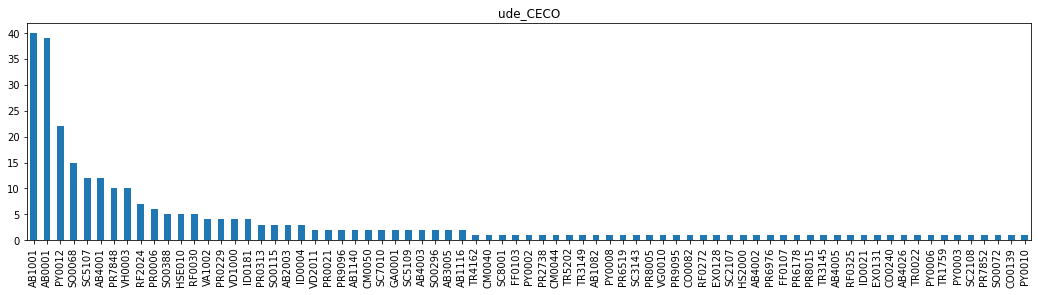

GERENCIA ADMINISTRAT                        13
GERENCIA ADMINISTRATIVA                      9
CORD PLANEAC GEST                            9
COORD CC VAO                                 9
COORDINACIÓN GESTIÓN DE CTAS POR PAGAR       7
                                            ..
DEPTOFINANCEXPLORA                           1
COORDINACIÓN DE GESTIÓN NÓMINA Y TIEMPOS     1
COORD GEST CONTRAT                           1
COORD DE INVENTARIOS Y BODEGAS               1
DEPTOFINANCVRE                               1
Name: ude_CentroDeCostos, Length: 69, dtype: int64

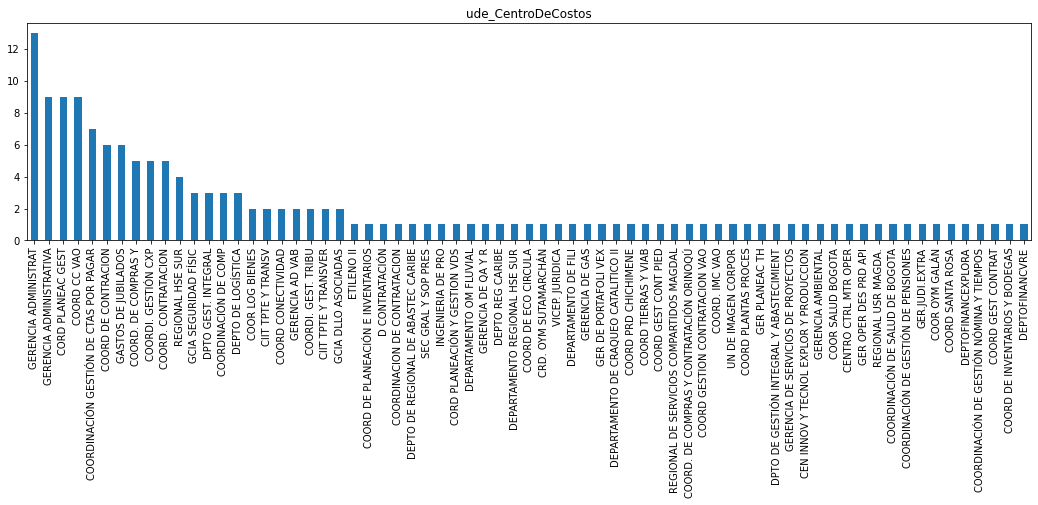

Puesto de Trabajo    9881
Transacciones        1342
Name: SistemaPago, dtype: int64

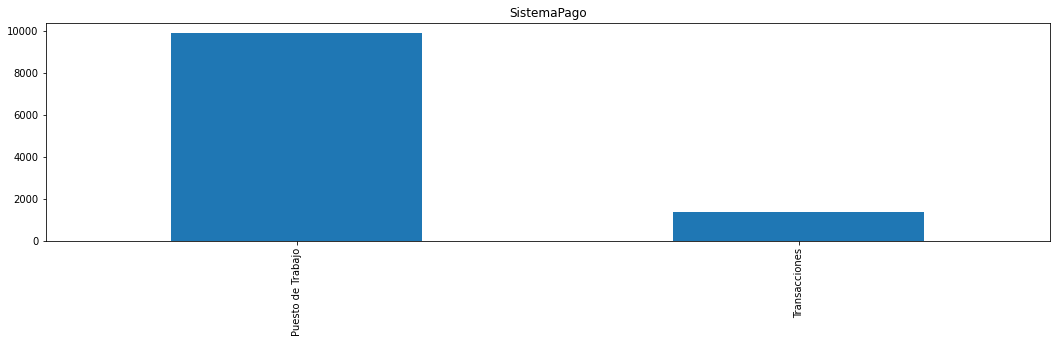

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: ServicioPortafolio, dtype: int64

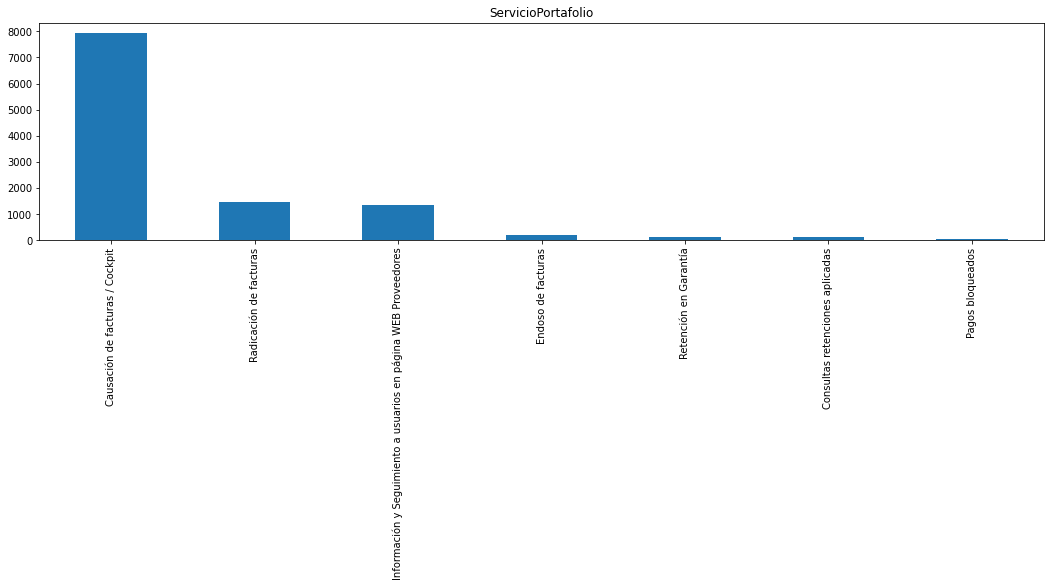

Cerrado     10716
Escalado      507
Name: fdp_NombreEstado, dtype: int64

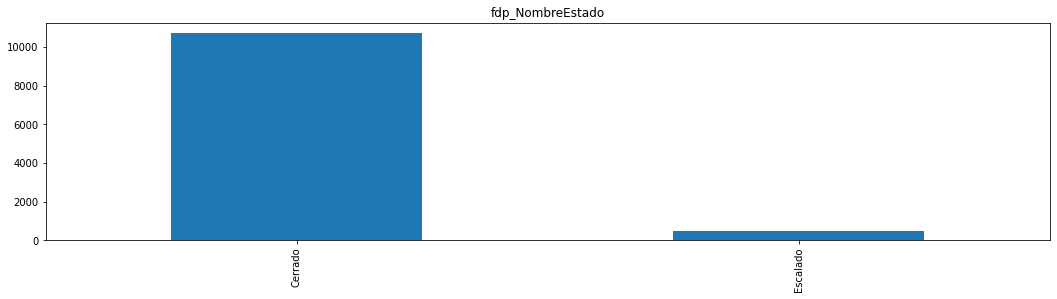

Nivel1    10381
Nivel2      842
Name: fdp_NivelEstado, dtype: int64

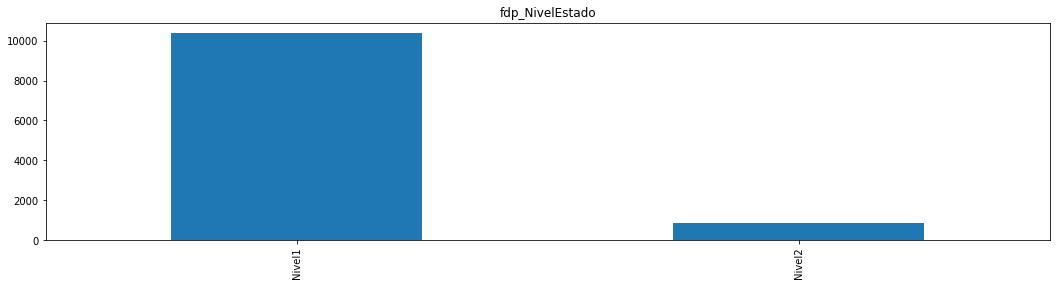

ANGIE CATHERINE BLANDON CACERES            1360
CLAUDIA MARCELA PINEDA                     1223
PAOLA ANDREA DAZA                          1180
EDGAR ANDRES GUZMAN HERNANDEZ              1146
LAURA MAYERLY BOHORQUEZ GAMBA              1077
JEIMY YOLIMA ARDILA PINZON                 1073
JEIMY NATHALY GOMEZ GOMEZ                  1038
NATHALIA ROJAS CLAVIJO                     1006
LINDA ALEJANDRA CAMACHO MURILLO             990
ESTEFANIA GUZMAN AGUDELO                    865
ALEX LILIAN TOVAR ORTIZ                     264
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioCreacion, dtype: int64

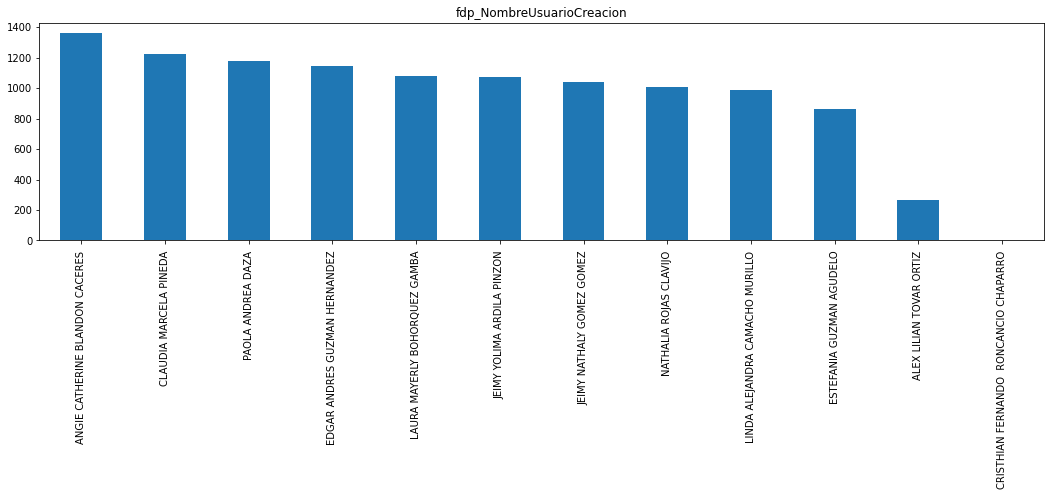

Asesor de Servicio BackOffice Contact Center    9881
Asesor de Servicio Contact Center               1342
Name: GrupoRolCreacion, dtype: int64

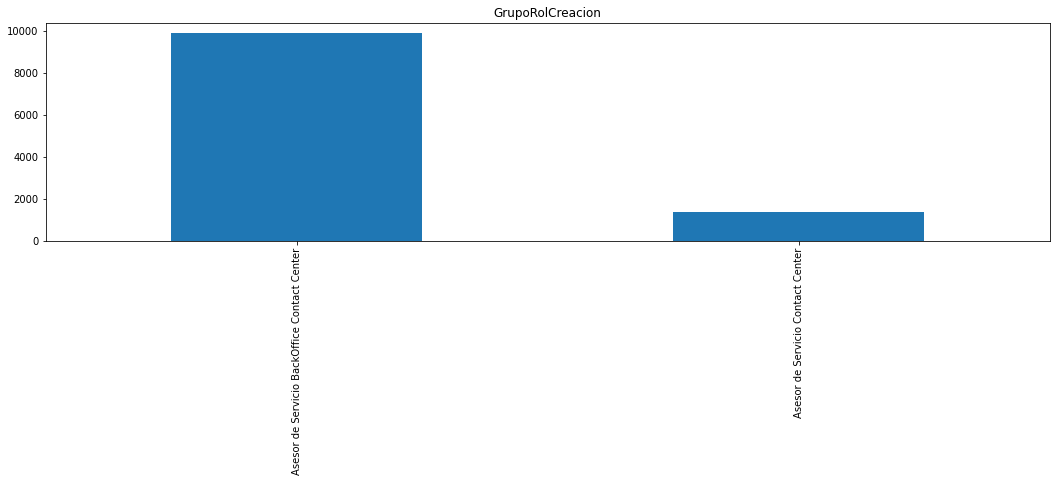

No Aplica    4486
Cumple       3446
No Cumple    3291
Name: Cumple_Objetivo_SolicitadoRegistrado, dtype: int64

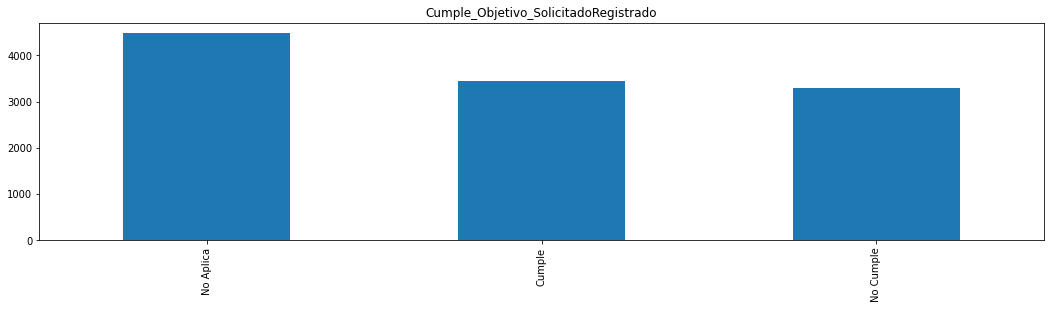

Cumple       11190
No Cumple       33
Name: Cumple_Objetivo_RegistradoEscalado, dtype: int64

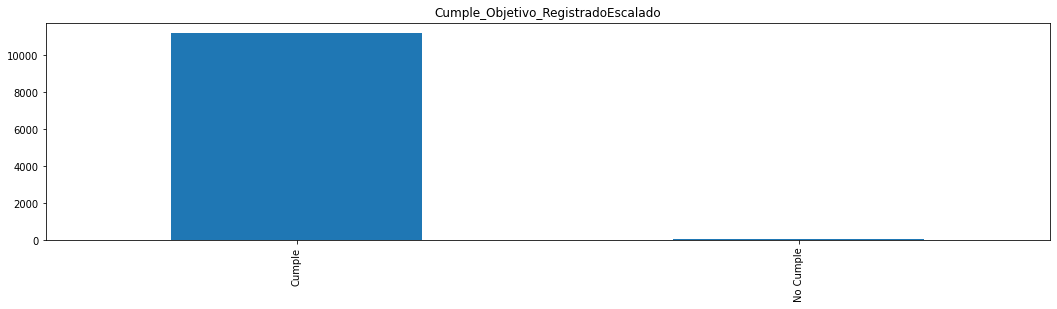

Equipo de Causación     838
Equipo de Radicación      4
Name: fdp_NombreGrupoEscalamientoN2, dtype: int64

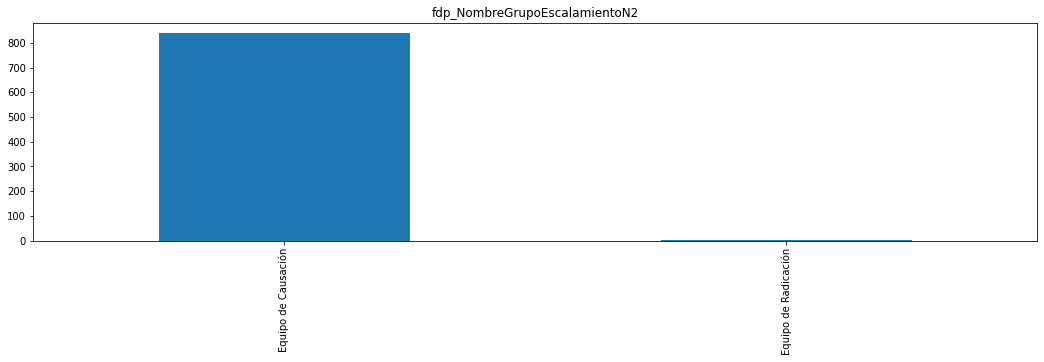

HAROL ESTIVEN SUAREZ BERNAL            181
ADRIANA PATRICIA COMBITA ALFONSO       145
CLAUDIA  NOVA CHAVEZ                   136
NANCY GAMBA LÓPEZ                      109
HARBEY WILFREDO CHAVARRIO ALVARADO     107
MARTHA ELENA BELLO FORERO               60
AMPARO DEL PILAR TORRES                 45
SANDRA PATRICIA ESTUPIÑAN SANDOVAL      30
EDISON MAURICIO CORTES LEON              6
DEXY OSPINA RIOS                         5
LISETT CAROLINA VINUEZA MALES            5
LEONARDO PINEDA ROJAS                    2
JULIAN ENRIQUE CAMACHO BECERRA           1
LIZBETH   PEREZ TORRES                   1
Name: fdp_NombreUsuarioEscalamientoN2, dtype: int64

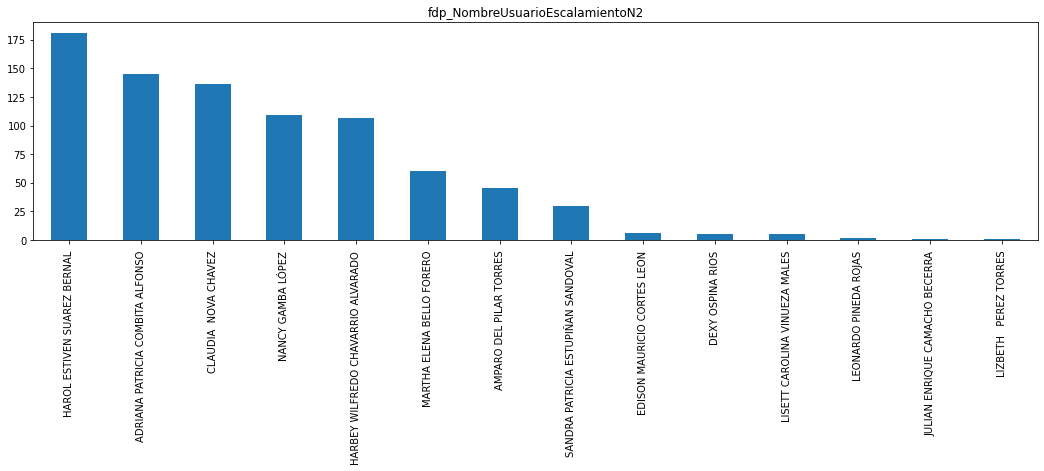

Asesor solucionador Ecopetrol              694
Asesor Solucionador Tercero                138
Asesor de Servicio Front Contact Center      1
Name: GrupoRolEscalamientoN2, dtype: int64

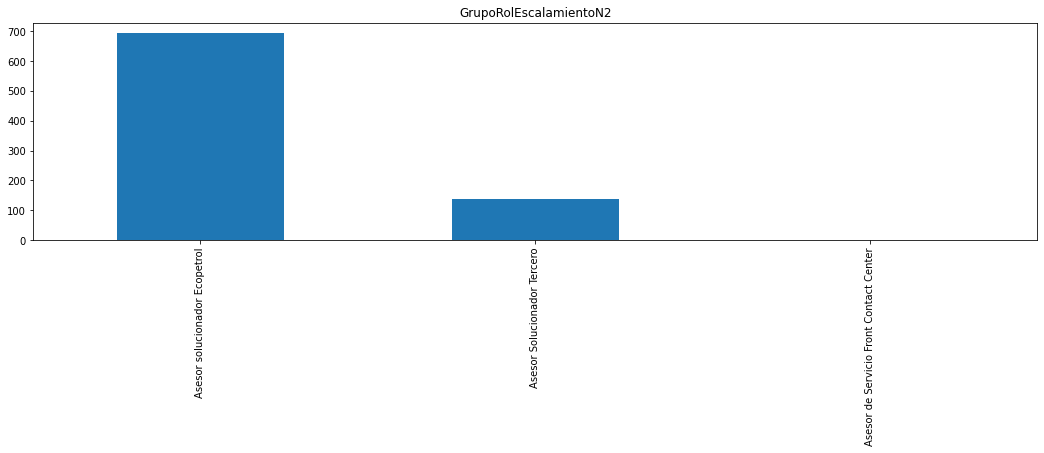

No Aplica    10888
Cumple         292
No Cumple       43
Name: Cumple_Objetivo_EnNivel2, dtype: int64

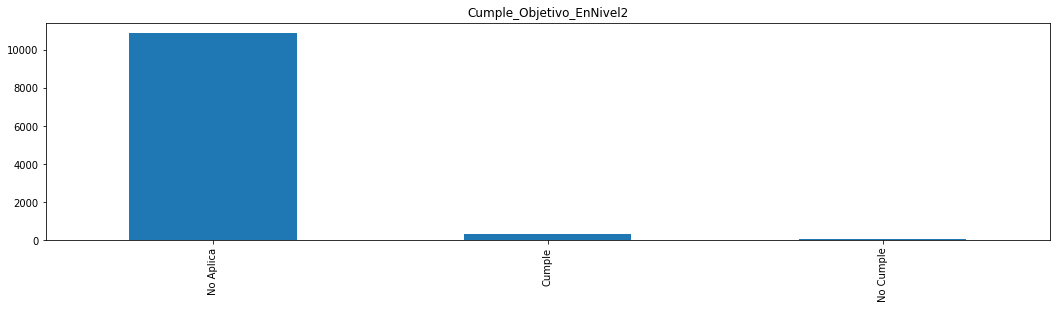

ANGIE CATHERINE BLANDON CACERES     9
CLAUDIA MARCELA PINEDA              8
LAURA MAYERLY BOHORQUEZ GAMBA       6
NATHALIA ROJAS CLAVIJO              2
LINDA ALEJANDRA CAMACHO MURILLO     2
Name: fdp_NombreUsuarioDevolucion, dtype: int64

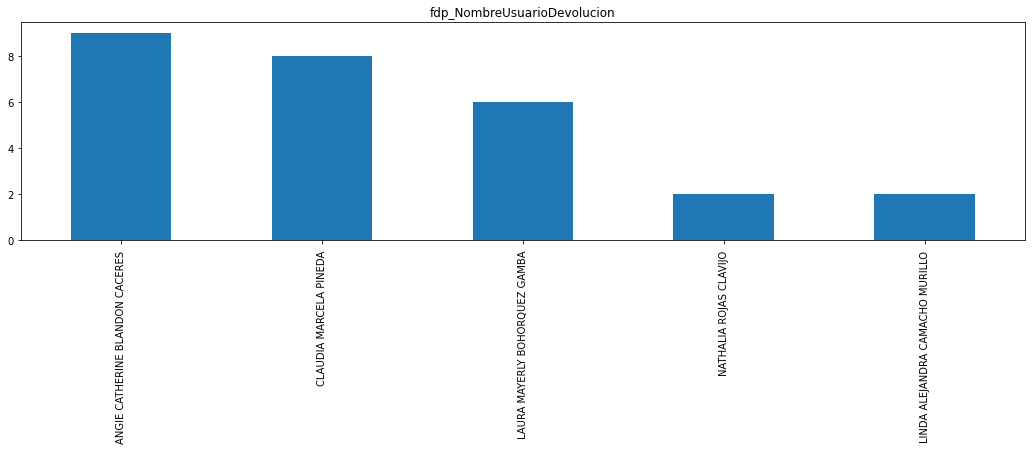

No tengo asignada la factura.                                                                                                                          4
Por favor direccionar al encargado responsable.                                                                                                        1
_Favor redireccionar a Nancy Gamba                                                                                                                     1
No tengo asignada la factura correspondiente                                                                                                           1
Reasignar al responsable E0992696                                                                                                                      1
No tengo asignada la factura en mención.                                                                                                               1
Por favor direccionar a la funcionaria Amparo Torres quien rechazo la factura y al

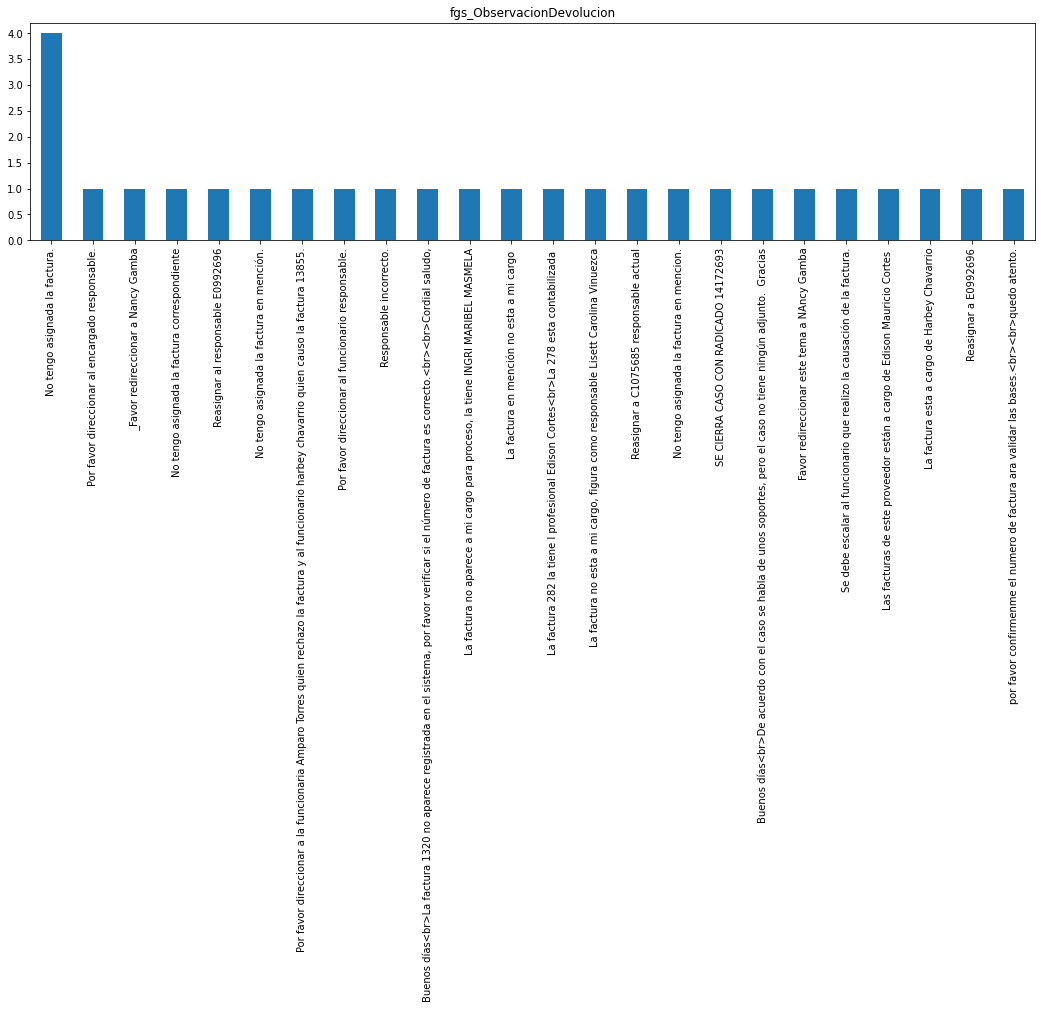

2021-03-15 21:07:37.637000    1
2021-05-25 12:39:34.237000    1
2021-03-13 07:52:16.150000    1
2021-03-23 13:30:03.140000    1
2021-03-15 16:43:51.233000    1
2021-04-19 14:30:08.297000    1
2021-03-13 07:55:41.017000    1
2021-03-15 16:46:07.737000    1
2021-03-12 19:15:24.797000    1
2021-03-21 22:16:21.900000    1
2021-02-27 08:39:34.367000    1
2021-04-11 19:34:49.583000    1
2021-05-18 16:25:00.273000    1
2021-03-13 08:14:08.413000    1
2021-03-12 19:17:02.827000    1
2021-04-11 10:14:19.227000    1
2021-03-15 16:37:46.097000    1
2021-05-09 08:30:37.367000    1
2021-05-04 16:34:06.210000    1
2021-04-11 09:54:46.040000    1
2021-03-15 16:40:05.543000    1
2021-05-31 08:46:04.693000    1
2021-03-13 07:41:32.923000    1
2021-03-12 19:15:54.417000    1
2021-05-18 16:27:04.350000    1
2021-03-15 21:08:36.827000    1
2021-03-18 19:26:17.137000    1
Name: fdp_FechaDevolucion, dtype: int64

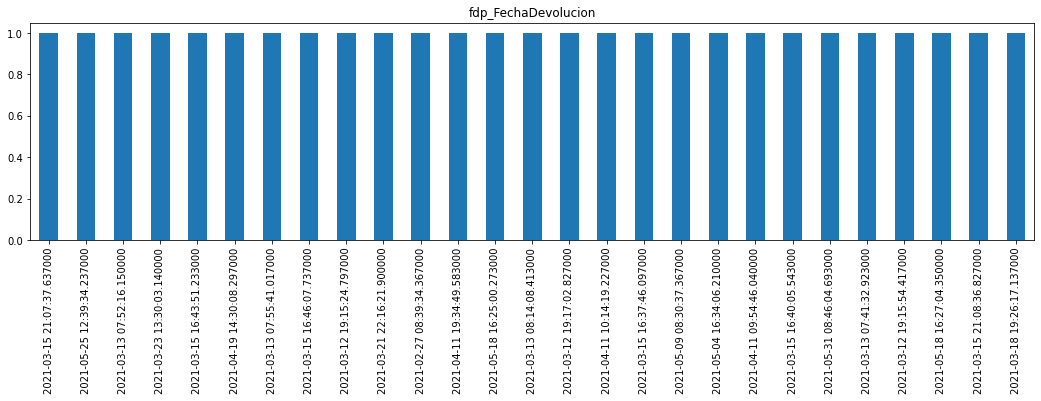

2021-03-15 07:30:00    2
2021-03-23 12:07:00    1
2021-04-15 08:03:00    1
2021-05-28 08:54:00    1
2021-03-15 12:40:00    1
2021-03-15 14:06:00    1
2021-03-15 09:17:00    1
2021-03-26 10:27:00    1
2021-03-29 07:30:00    1
2021-04-13 15:33:00    1
2021-03-23 11:08:00    1
2021-03-18 07:30:00    1
2021-03-04 15:58:00    1
2021-05-11 09:11:00    1
2021-05-25 11:29:00    1
2021-03-16 09:12:00    1
2021-03-15 14:08:00    1
2021-04-23 10:00:00    1
2021-03-26 09:29:00    1
2021-03-16 10:46:00    1
2021-05-10 15:31:00    1
2021-03-15 14:25:00    1
2021-04-13 12:03:00    1
2021-05-25 07:37:00    1
2021-06-01 12:48:00    1
2021-03-16 16:27:00    1
Name: fdp_FechaVencimientoDevolucion, dtype: int64

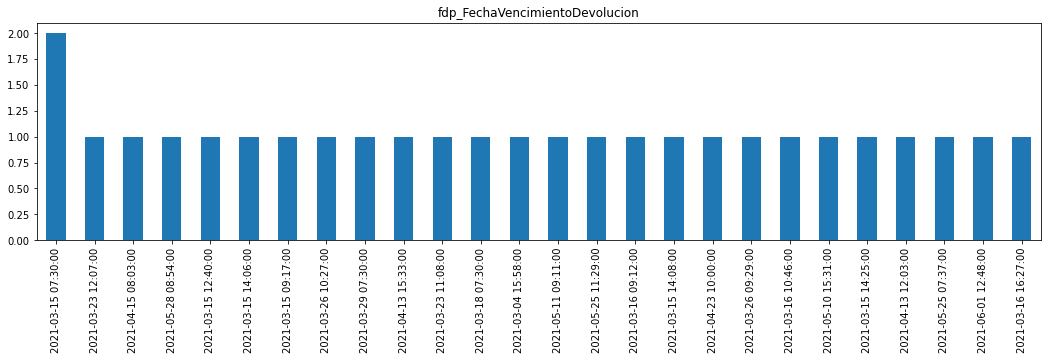

Asesor de Servicio BackOffice Contact Center    21
Asesor de Servicio Contact Center                6
Name: GrupoRolDevolucion, dtype: int64

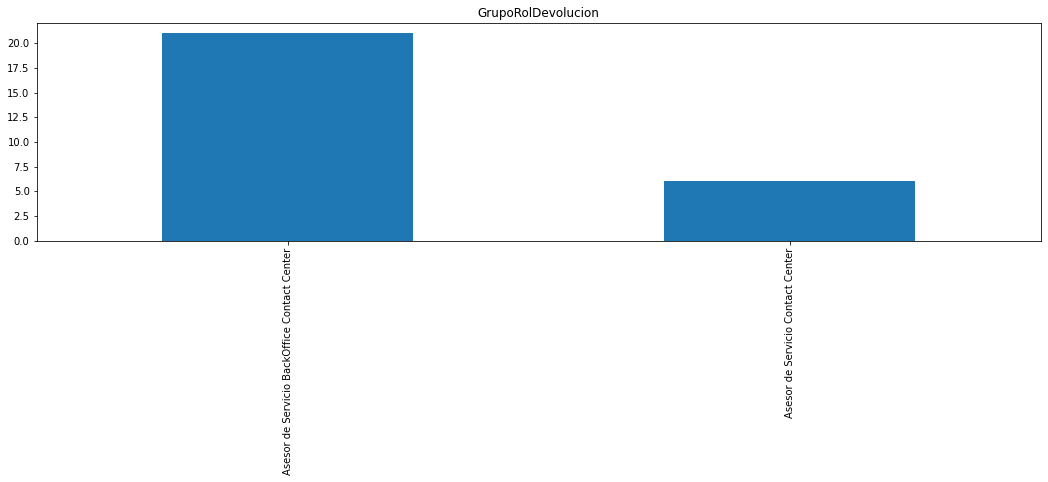

Escalado al responsable de solución equivocado                                     23
No se encuentra formato de soporte o no es legible                                  2
Recepción de solicitud incompleta  no se validaron correctamente los requisitos     1
Name: fdp_MotivoDevolucion, dtype: int64

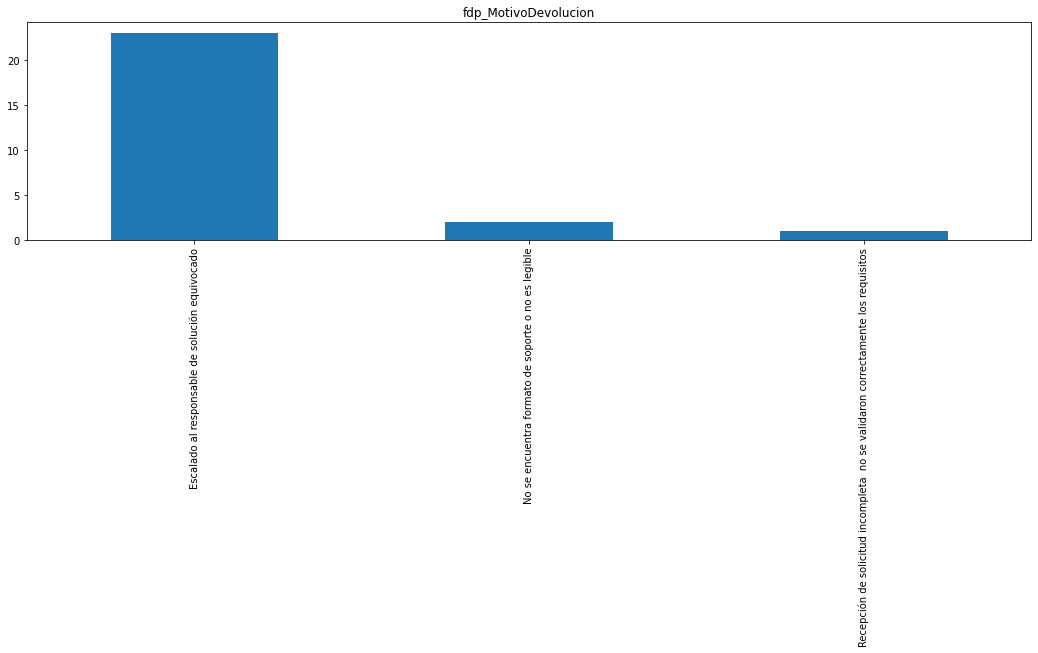

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             335
Name: fdp_NombreGrupoSolucion, dtype: int64

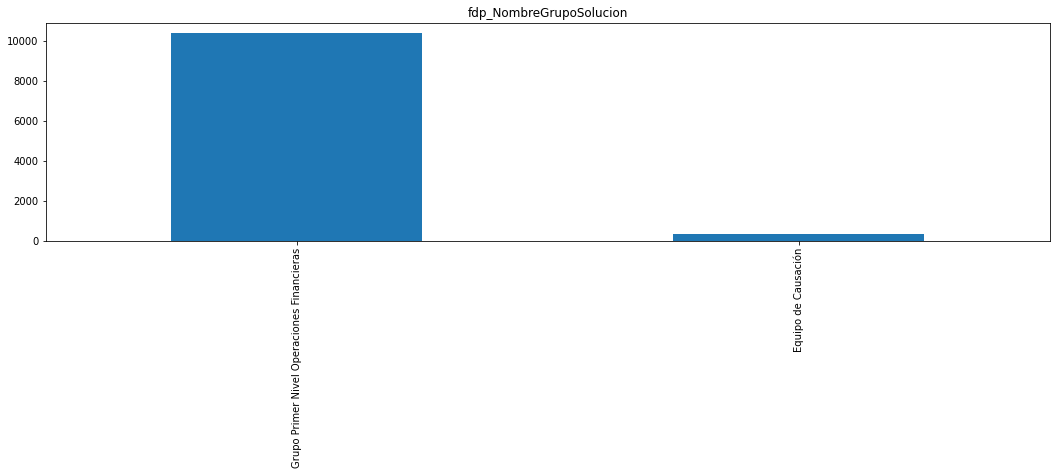

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
ADRIANA PATRICIA COMBITA ALFONSO            147
NANCY GAMBA LÓPEZ                           109
AMPARO DEL PILAR TORRES                      43
HARBEY WILFREDO CHAVARRIO ALVARADO           36
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioSolucion, dtype: int64

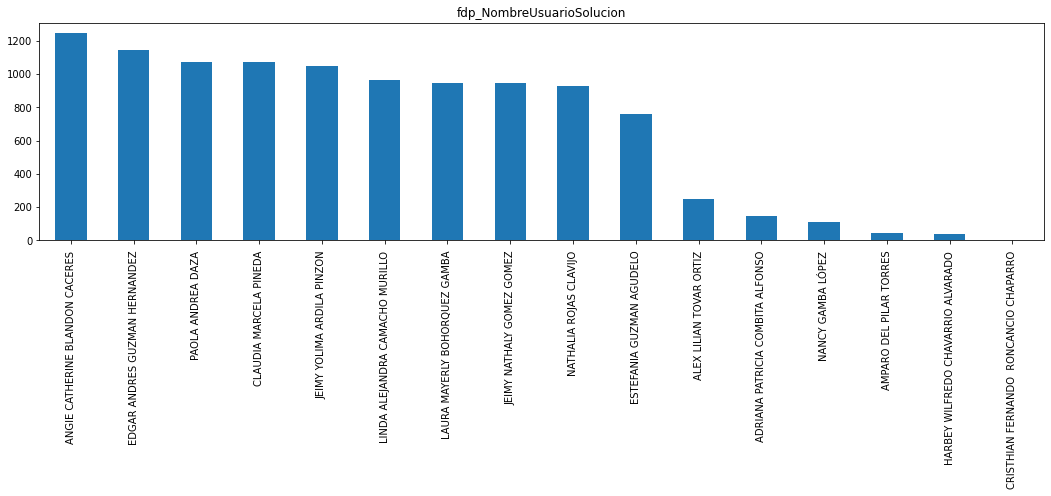

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    335
Name: GrupoRolSolucion, dtype: int64

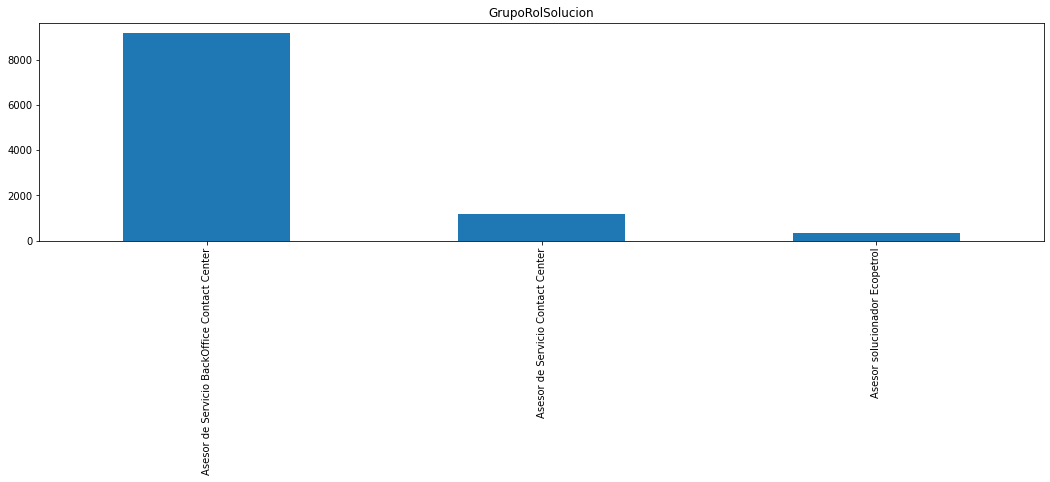

Nivel1    10381
Nivel2      335
Name: fdp_NivelSolucion, dtype: int64

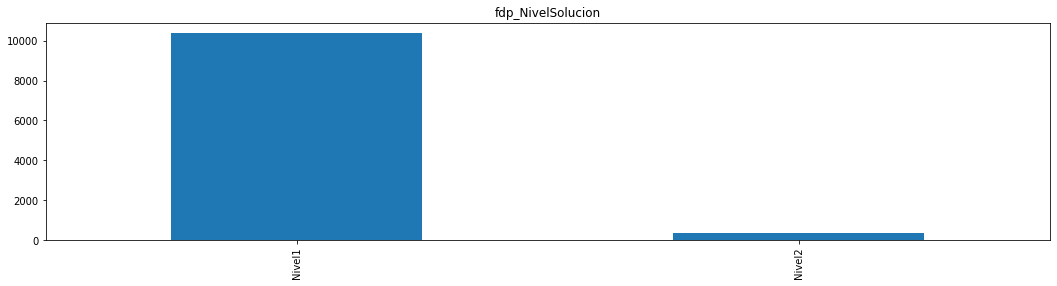

Cumple       10716
No Aplica      507
Name: Cumple_Objetivo_SolucionadoCerrado, dtype: int64

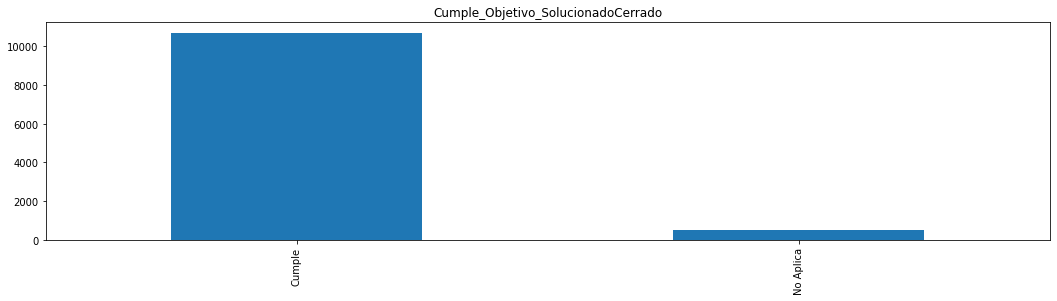

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             335
Name: fdp_NombreGrupoCierre, dtype: int64

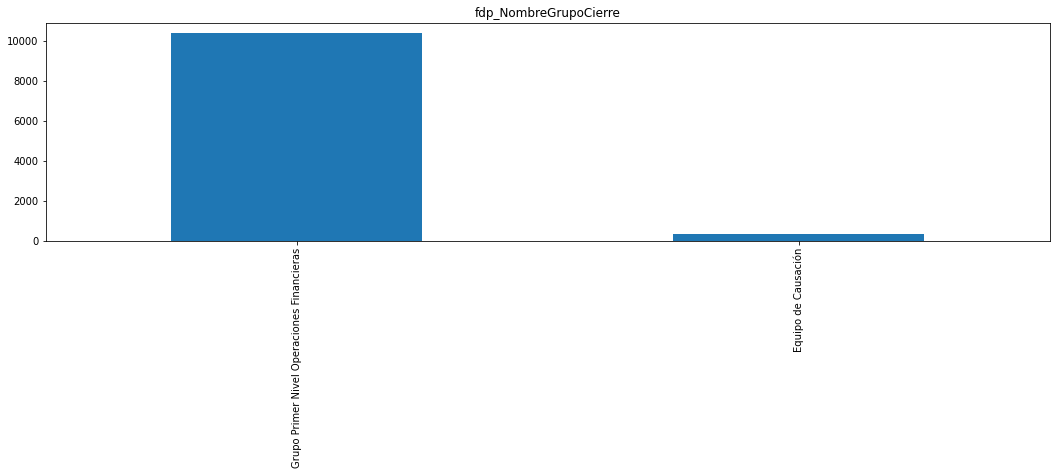

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
ADRIANA PATRICIA COMBITA ALFONSO            147
NANCY GAMBA LÓPEZ                           109
AMPARO DEL PILAR TORRES                      43
HARBEY WILFREDO CHAVARRIO ALVARADO           36
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioCierre, dtype: int64

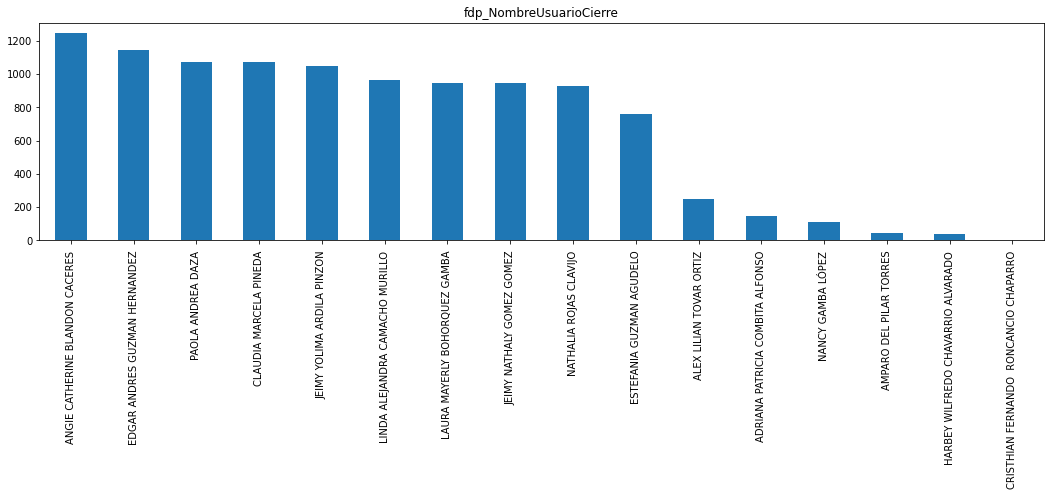

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    335
Name: GrupoRolCierre, dtype: int64

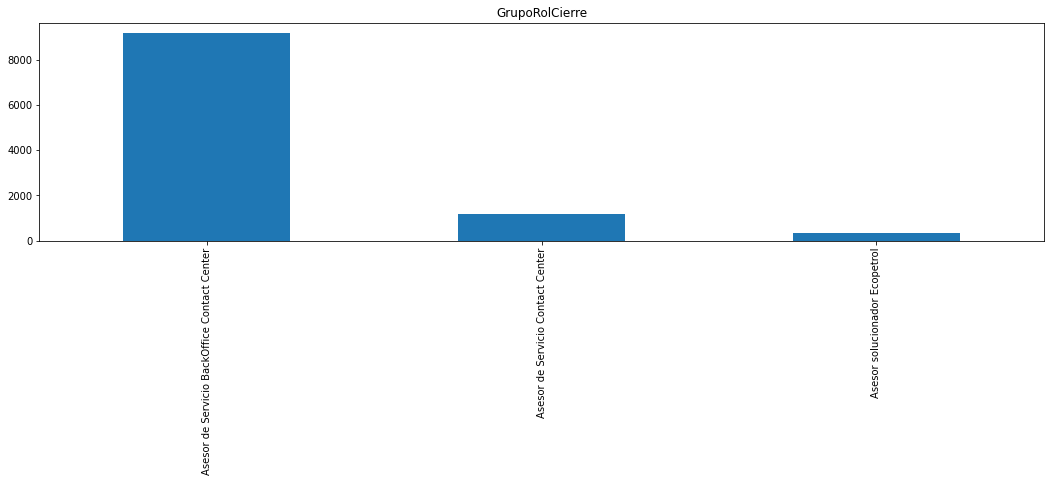

Nivel1    10381
Nivel2      335
Name: fdp_NivelCierre, dtype: int64

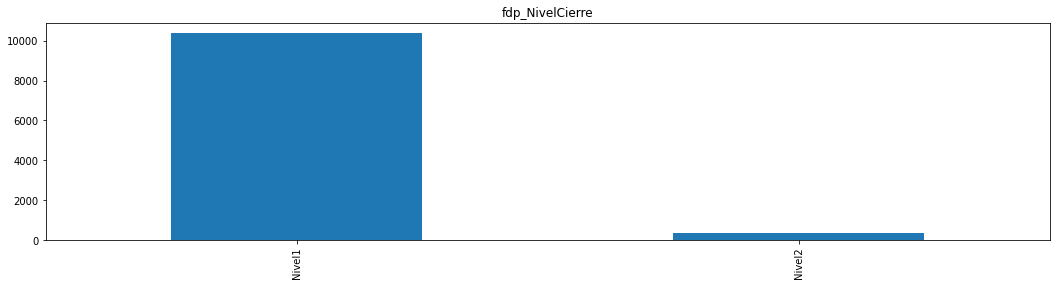

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             838
Equipo de Radicación                              4
Name: fdp_NombreGrupoGestionActual, dtype: int64

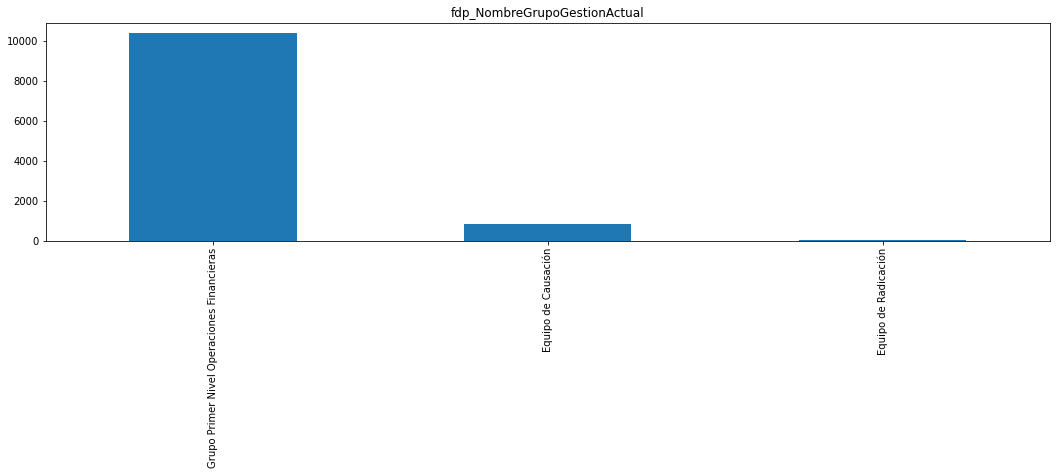

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
HAROL ESTIVEN SUAREZ BERNAL                 183
ADRIANA PATRICIA COMBITA ALFONSO            147
CLAUDIA  NOVA CHAVEZ                        137
NANCY GAMBA LÓPEZ                           110
HARBEY WILFREDO CHAVARRIO ALVARADO          108
MARTHA ELENA BELLO FORERO                    61
AMPARO DEL PILAR TORRES                      45
SANDRA PATRICIA ESTUPIÑAN SANDOVAL           30
EDISON MAURICIO CORTES LEON                   6
LISETT CAROLINA VINUEZA MALES           

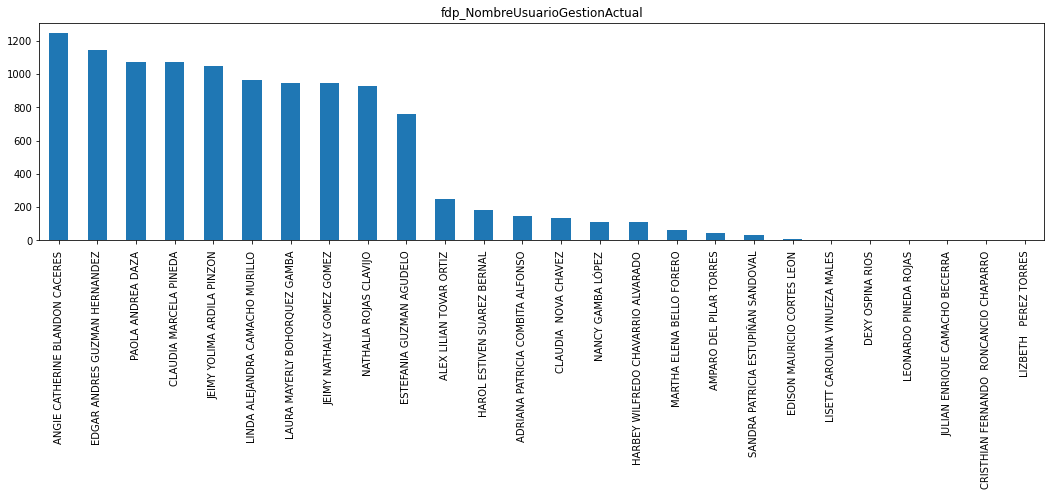

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    701
Asesor Solucionador Tercero                      138
Asesor de Servicio Front Contact Center            1
Name: GrupoRolGestionActual, dtype: int64

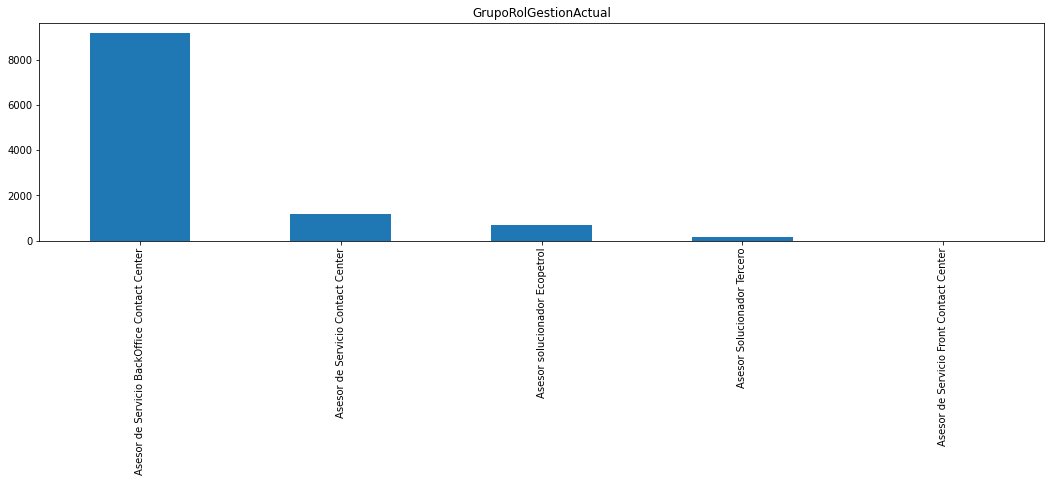

Nivel1    10381
Nivel2      842
Name: fdp_NivelGestionActual, dtype: int64

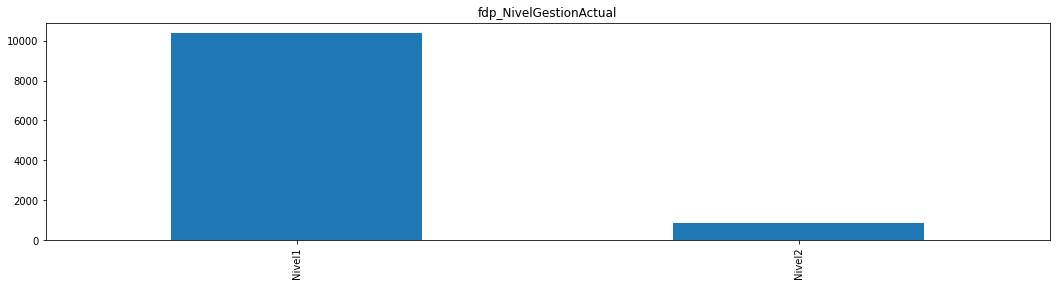

Fecha Superior a la fecha de creación o Fecha Nula      6191
Fecha de Modificación Menor a la del estado anterior     867
No Registra Canal                                          1
Name: TipoAjuste, dtype: int64

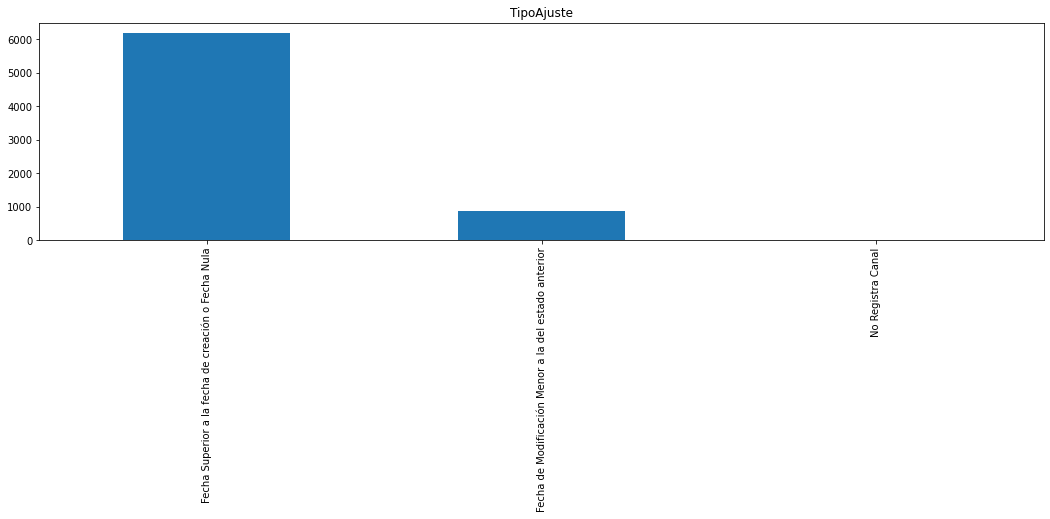

In [59]:
lista_menores = []
lista_mayores = []
for i in objetos.columns:
  
  if objetos[i].nunique()<=100:
    display(objetos[i].value_counts())
    objetos[i].value_counts().plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)
# nota aparece un valor con un valor pero se deve a que despues de la limpieza se elimino 'Prestador de Servicios de Salud'

count    1.122300e+04
mean     1.609180e+10
std      2.614531e+11
min      1.000000e+02
5%       7.972226e+07
25%      8.002378e+09
50%      8.600058e+09
75%      9.003005e+09
95%      9.011237e+09
99%      9.014032e+09
max      8.226125e+12
Name: fgs_NumeroDocumContacto, dtype: float64

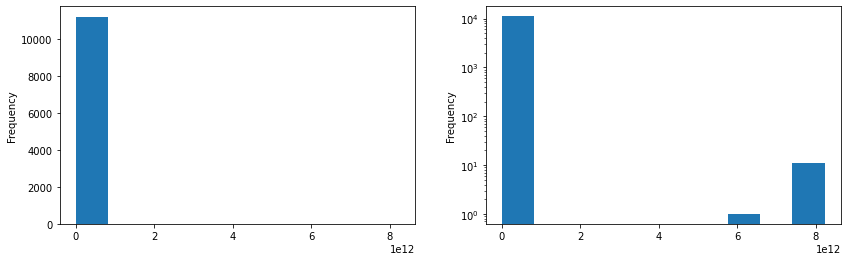

count    11223.000000
mean      7590.224450
std        597.304313
min       7367.000000
5%        7367.000000
25%       7367.000000
50%       7367.000000
75%       7373.000000
95%       9198.000000
99%       9198.000000
max       9198.000000
Name: fgs_IdTipificacionGestionDetalle, dtype: float64

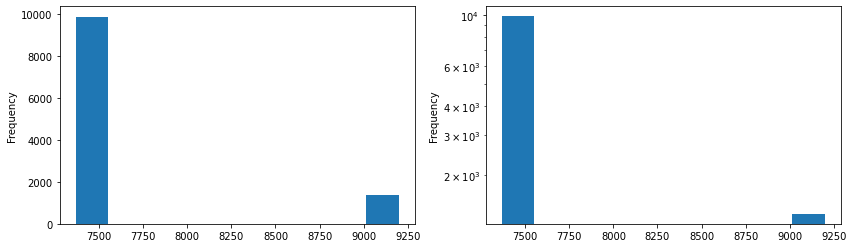

count    1.510000e+02
mean     1.360638e+07
std      1.763559e+07
min      1.000004e+07
5%       1.000028e+07
25%      1.000317e+07
50%      1.000440e+07
75%      1.000528e+07
95%      1.000611e+07
99%      1.000000e+08
max      1.000000e+08
Name: ude_CodUni, dtype: float64

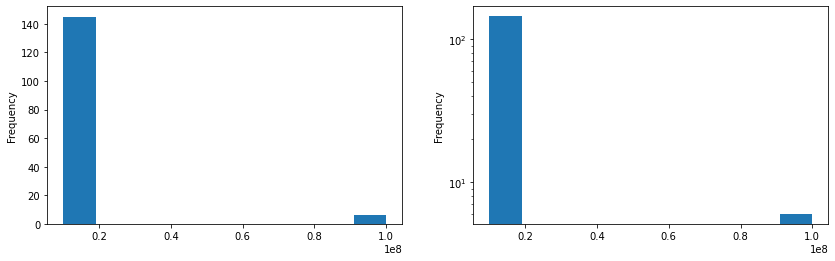

count     11223.000000
mean      18626.509935
std       64586.094259
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
95%      231673.400000
99%      266812.620000
max      282462.000000
Name: fdp_IdPqr, dtype: float64

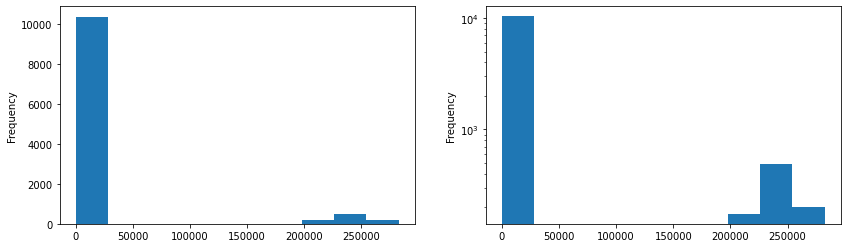

count    11223.000000
mean         1.045175
std          0.207697
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          1.000000
95%          1.000000
99%          2.000000
max          2.000000
Name: fdp_IdEstado, dtype: float64

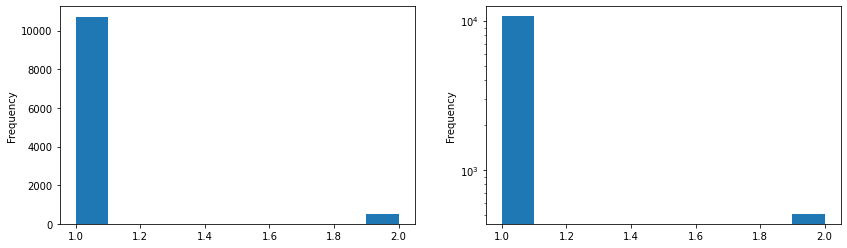

count    867.000000
mean     654.004614
std        0.067806
min      654.000000
5%       654.000000
25%      654.000000
50%      654.000000
75%      654.000000
95%      654.000000
99%      654.000000
max      655.000000
Name: fdp_IdFlujo, dtype: float64

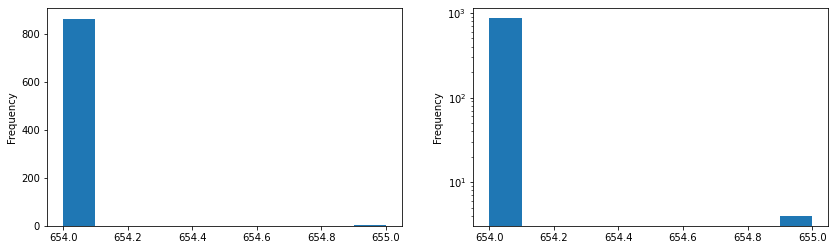

count    11223.000000
mean         2.766640
std          0.803543
min          0.000000
5%           0.000000
25%          3.000000
50%          3.000000
75%          3.000000
95%          3.000000
99%          3.000000
max          3.000000
Name: fdp_IdHistoricoPqrCreacion, dtype: float64

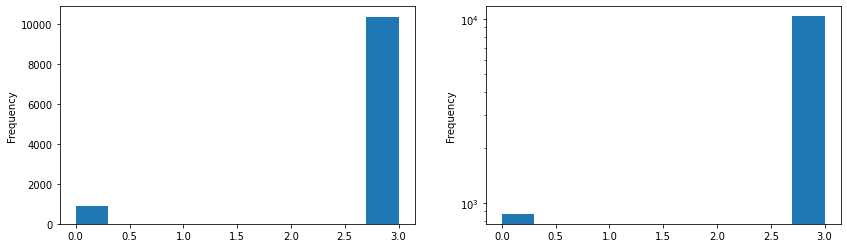

count    11223.000000
mean       122.679408
std         45.815392
min         57.000000
5%          57.000000
25%        103.000000
50%        135.000000
75%        147.000000
95%        187.000000
99%        187.000000
max       2666.000000
Name: fdp_IdUsuarioCreacion, dtype: float64

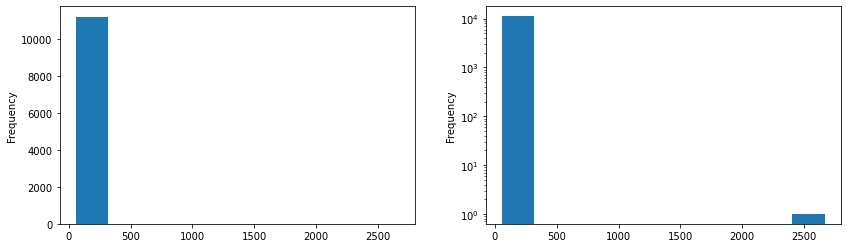

count    1.122300e+04
mean     8.013963e+08
std      4.165276e+08
min      5.276967e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioCreacion, dtype: float64

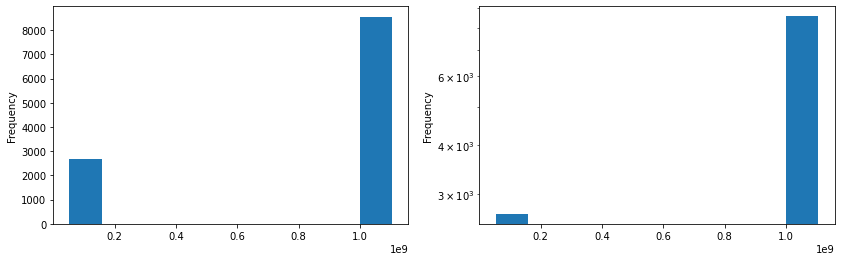

count    11223.000000
mean         7.162969
std          2.271356
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolCreacion, dtype: float64

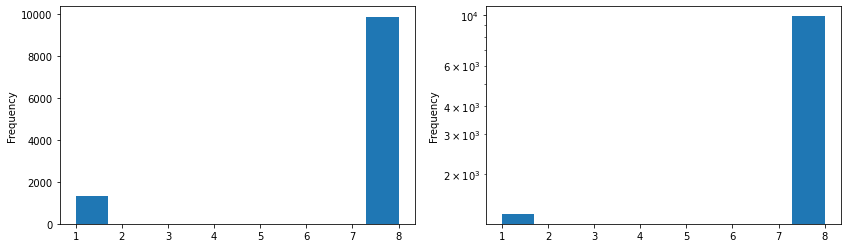

count     6737.000000
mean       328.788185
std        997.219590
min          0.000000
5%           0.000000
25%         43.000000
50%        116.000000
75%        274.000000
95%        938.000000
99%       6288.280000
max      20085.000000
Name: T_Real_SolicitadoRegistrado, dtype: float64

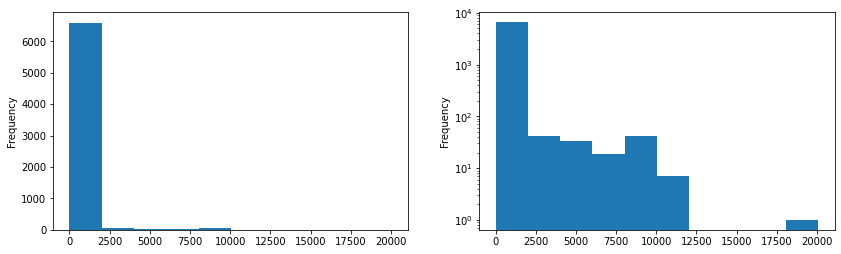

count    11223.000000
mean         5.951617
std        136.565443
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%          0.000000
max       7286.000000
Name: T_Real_RegistradoEscalado, dtype: float64

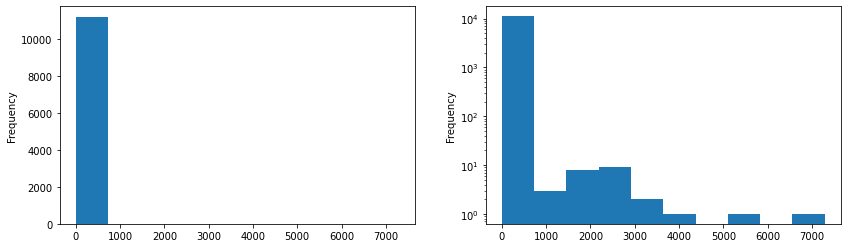

count       842.000000
mean     719117.971496
std       61793.713903
min      583910.000000
5%       635729.400000
25%      676056.000000
50%      706288.500000
75%      760445.000000
95%      839252.400000
99%      852704.740000
max      855136.000000
Name: fdp_IdHistoricoPqrEscalamientoN2, dtype: float64

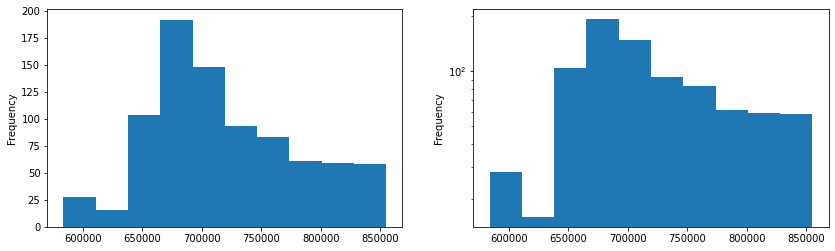

count    842.000000
mean     534.004751
std        0.068802
min      534.000000
5%       534.000000
25%      534.000000
50%      534.000000
75%      534.000000
95%      534.000000
99%      534.000000
max      535.000000
Name: fdp_IdGrupoEscalamientoN2, dtype: float64

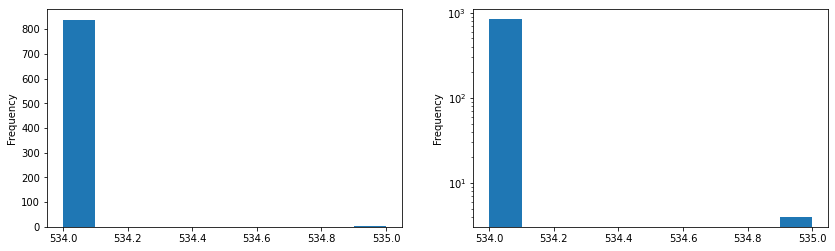

count     842.000000
mean     1408.011876
std         0.145815
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1408.000000
99%      1408.000000
max      1410.000000
Name: fdp_IdDetalleFlujoEscalamientoN2, dtype: float64

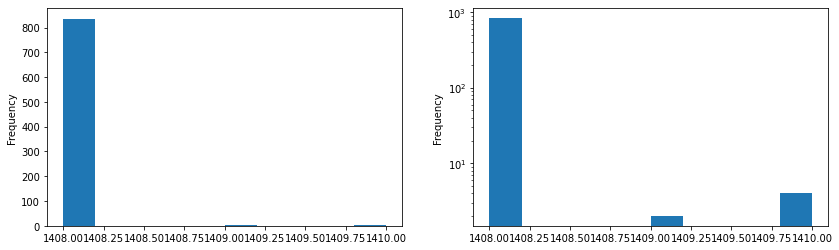

count     833.000000
mean      910.601441
std       858.602529
min       125.000000
5%        370.000000
25%       455.000000
50%       553.000000
75%       682.000000
95%      2761.000000
99%      2761.000000
max      2761.000000
Name: fdp_IdUsuarioEscalamientoN2, dtype: float64

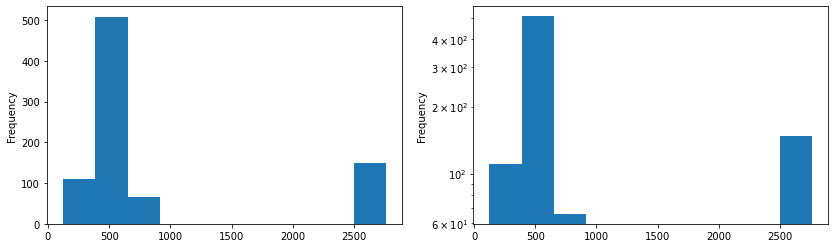

count    8.330000e+02
mean     2.045782e+08
std      3.436955e+08
min      1.386082e+07
5%       3.542411e+07
25%      5.200607e+07
50%      6.033386e+07
75%      8.003256e+07
95%      1.032384e+09
99%      1.032384e+09
max      1.075685e+09
Name: fdp_UsuarioEscalamientoN2, dtype: float64

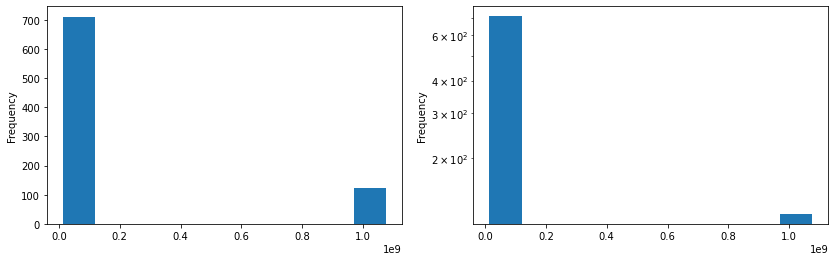

count    833.000000
mean       6.162065
std        0.387796
min        3.000000
5%         6.000000
25%        6.000000
50%        6.000000
75%        6.000000
95%        7.000000
99%        7.000000
max        7.000000
Name: CodigoGrupoRolEscalamientoN2, dtype: float64

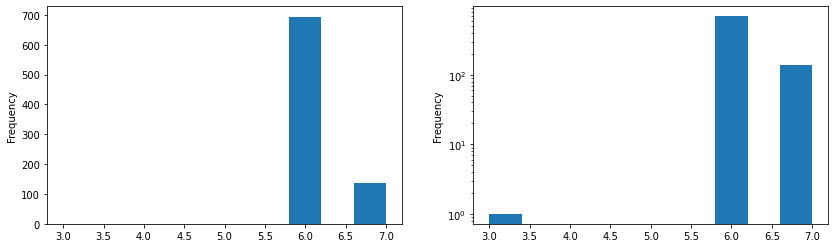

count     842.0
mean     2700.0
std         0.0
min      2700.0
5%       2700.0
25%      2700.0
50%      2700.0
75%      2700.0
95%      2700.0
99%      2700.0
max      2700.0
Name: T_Objetivo_EnNivel2, dtype: float64

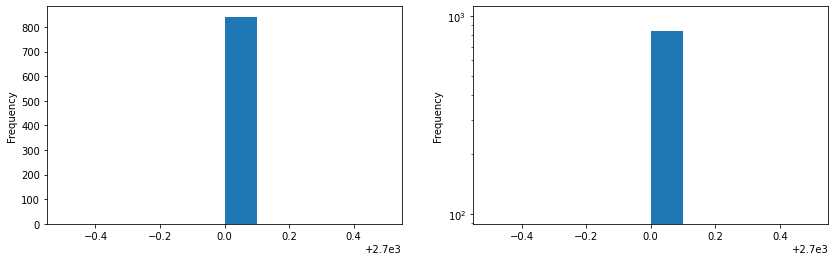

count    10691.000000
mean        55.452904
std        421.544615
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%       2133.900000
max       9720.000000
Name: T_Real_EnNivel2, dtype: float64

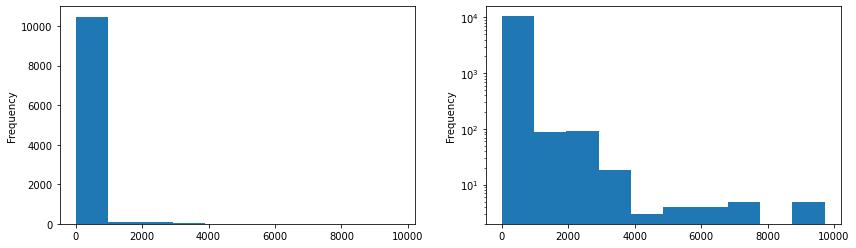

count        27.000000
mean     716898.851852
std       63884.639750
min      637444.000000
5%       671037.300000
25%      671507.500000
50%      675653.000000
75%      746265.500000
95%      835533.900000
99%      849657.120000
max      852813.000000
Name: fdp_IdHistoricoPqrDevolucion, dtype: float64

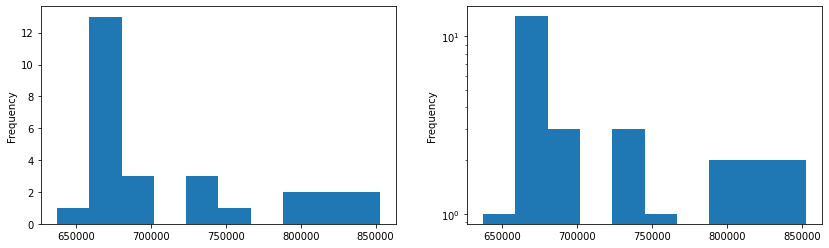

count     27.000000
mean     120.481481
std       38.143827
min       65.000000
5%        65.000000
25%       65.000000
50%      147.000000
75%      151.000000
95%      151.000000
99%      151.000000
max      151.000000
Name: fdp_IdUsuarioDevolucion, dtype: float64

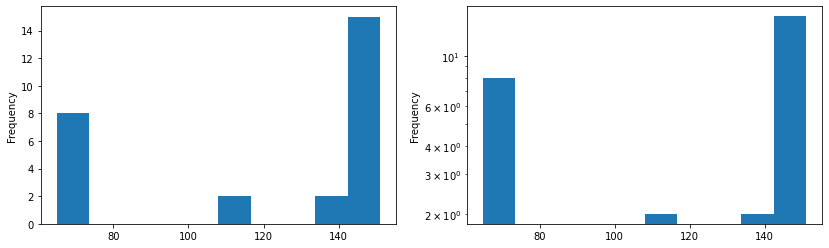

count    2.700000e+01
mean     7.381329e+08
std      4.531209e+08
min      5.291254e+07
5%       5.291254e+07
25%      5.291254e+07
50%      1.026290e+09
75%      1.030580e+09
95%      1.030580e+09
99%      1.030580e+09
max      1.030580e+09
Name: fdp_UsuarioDevolucion, dtype: float64

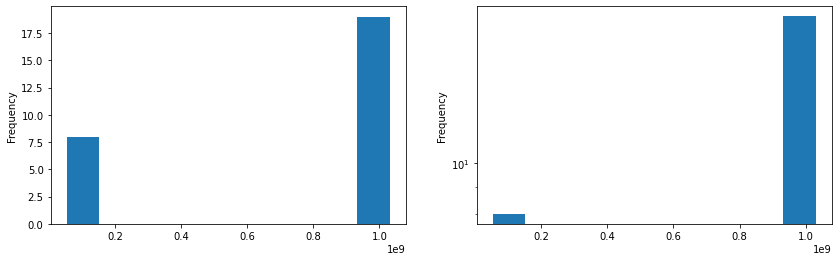

count    27.000000
mean      6.444444
std       2.965615
min       1.000000
5%        1.000000
25%       8.000000
50%       8.000000
75%       8.000000
95%       8.000000
99%       8.000000
max       8.000000
Name: CodigoGrupoRolDevolucion, dtype: float64

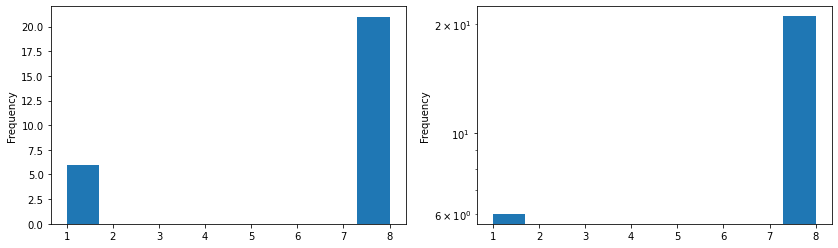

count     10716.000000
mean      24456.637925
std      131624.095225
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%           4.000000
99%      770110.700000
max      852933.000000
Name: fdp_IdHistoricoPqrSolucion, dtype: float64

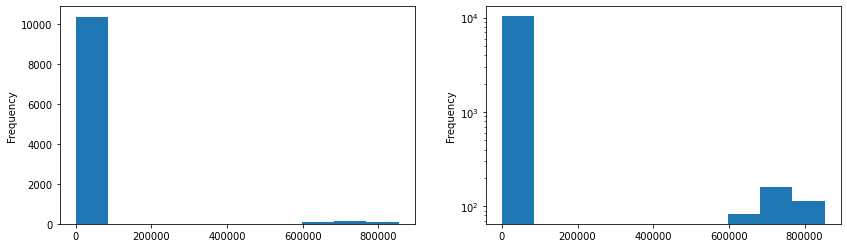

count    10716.000000
mean        17.813550
std         95.579785
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%        534.000000
max        534.000000
Name: fdp_IdGrupoSolucion, dtype: float64

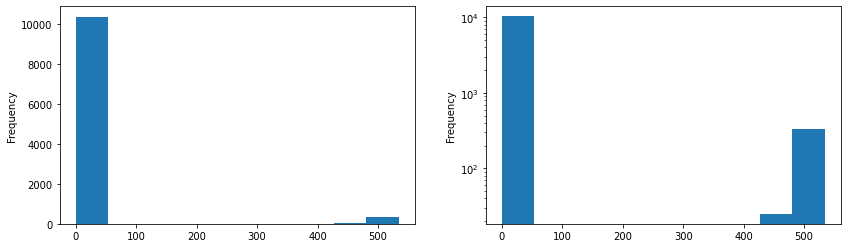

count     360.000000
mean     1408.075000
std         0.263758
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1409.000000
99%      1409.000000
max      1409.000000
Name: fdp_IdDetalleFlujoSolucion, dtype: float64

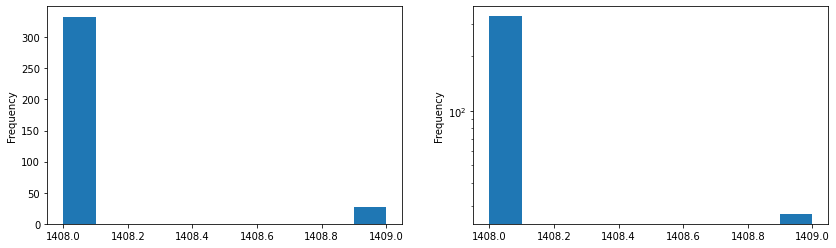

count    10716.000000
mean       135.684677
std         84.546224
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        187.000000
99%        625.000000
max       2666.000000
Name: fdp_IdUsuarioSolucion, dtype: float64

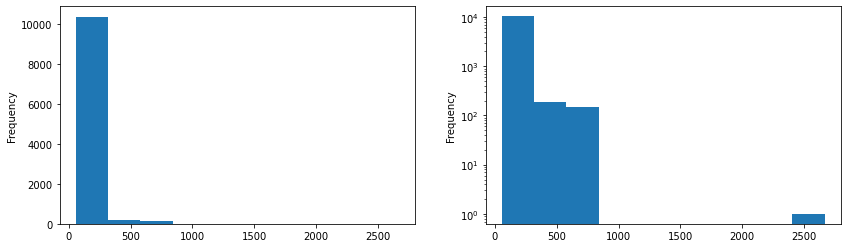

count    1.071600e+04
mean     7.957149e+08
std      4.204933e+08
min      5.200607e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioSolucion, dtype: float64

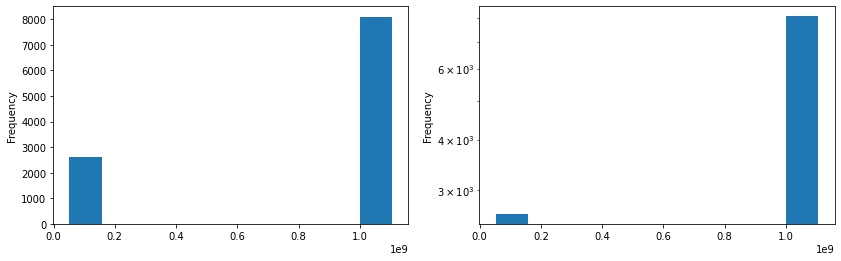

count    10716.000000
mean         7.154909
std          2.211176
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolSolucion, dtype: float64

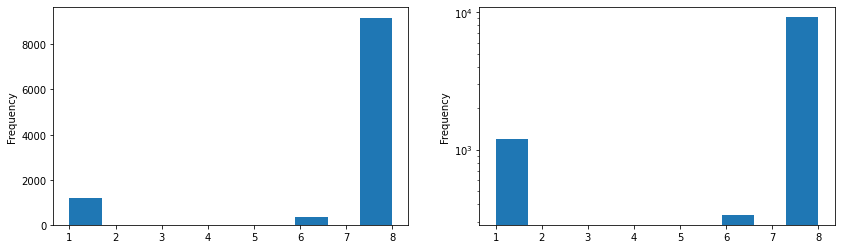

count     10716.000000
mean      24456.671706
std      131624.275869
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%           4.000000
99%      770111.700000
max      852934.000000
Name: fdp_IdHistoricoPqrCierre, dtype: float64

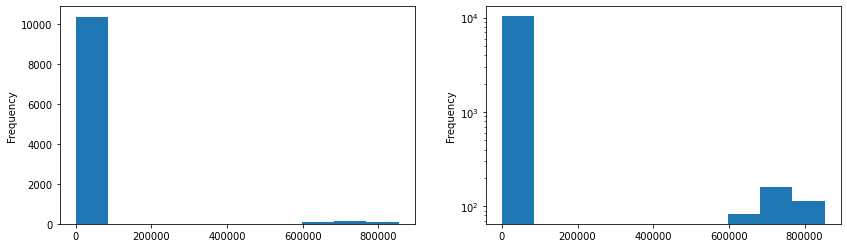

count    10716.000000
mean        17.813550
std         95.579785
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%        534.000000
max        534.000000
Name: fdp_IdGrupoCierre, dtype: float64

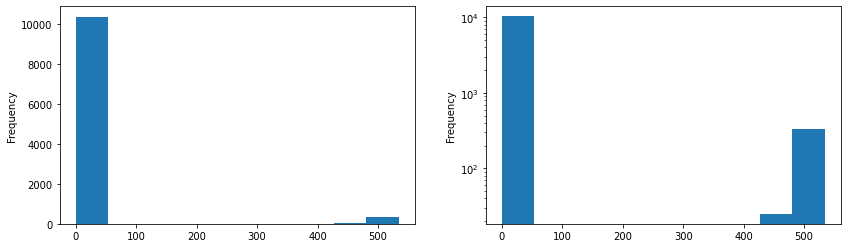

count     360.000000
mean     1408.075000
std         0.263758
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1409.000000
99%      1409.000000
max      1409.000000
Name: fdp_IdDetalleFlujoCierre, dtype: float64

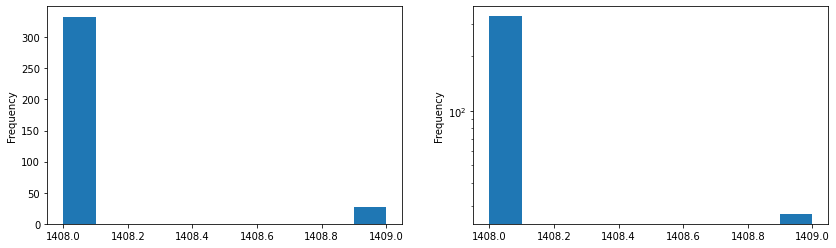

count    10716.000000
mean       135.684677
std         84.546224
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        187.000000
99%        625.000000
max       2666.000000
Name: fdp_IdUsuarioCierre, dtype: float64

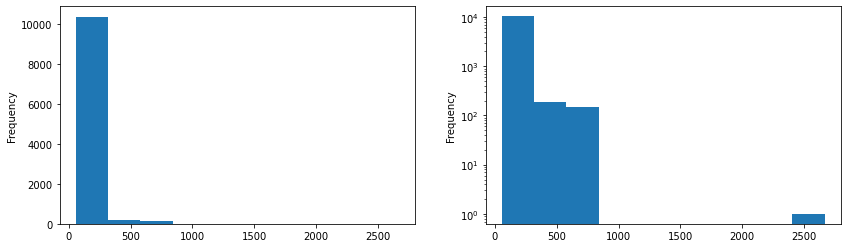

count    1.071600e+04
mean     7.957149e+08
std      4.204933e+08
min      5.200607e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioCierre, dtype: float64

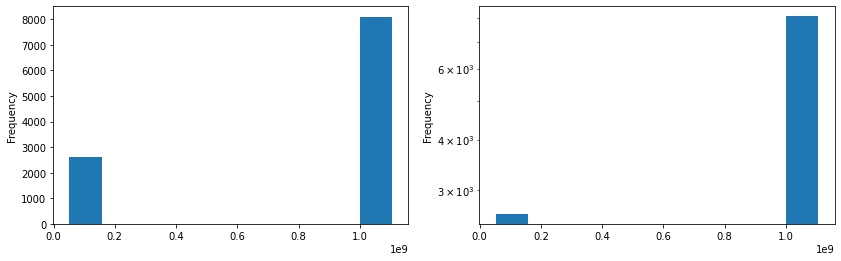

count    10716.000000
mean         7.154909
std          2.211176
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolCierre, dtype: float64

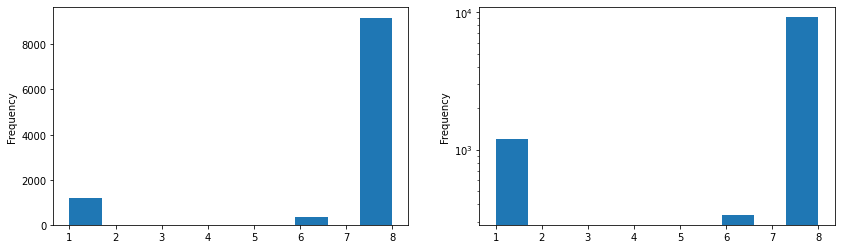

count     842.0
mean     2700.0
std         0.0
min      2700.0
5%       2700.0
25%      2700.0
50%      2700.0
75%      2700.0
95%      2700.0
99%      2700.0
max      2700.0
Name: T_Objetivo_Total, dtype: float64

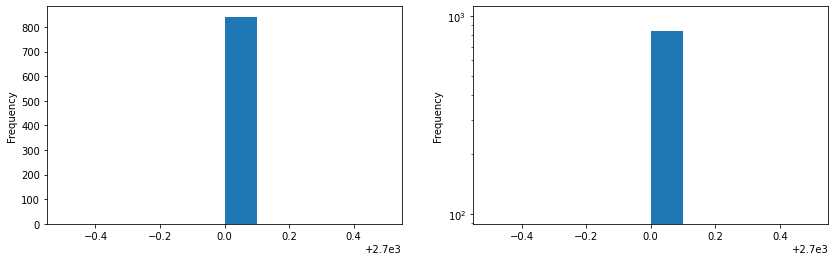

count     11223.000000
mean      55904.296267
std      193974.630976
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%      689395.800000
99%      806621.320000
max      855136.000000
Name: fdp_IdHistoricoPqrGestionActual, dtype: float64

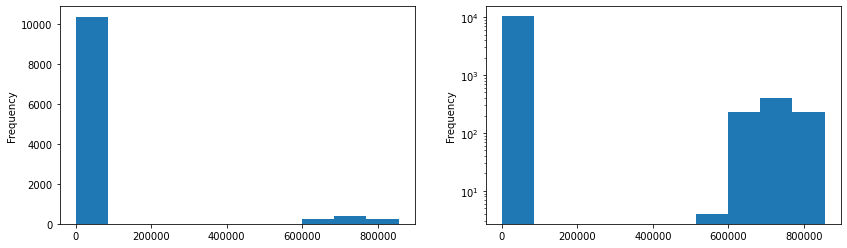

count    11223.000000
mean        41.132674
std        142.187217
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%        534.000000
99%        534.000000
max        535.000000
Name: fdp_IdGrupoGestionActual, dtype: float64

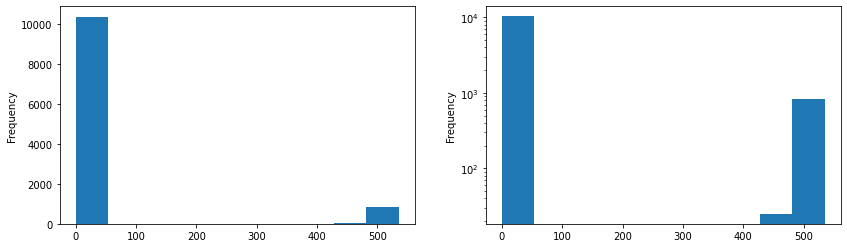

count     867.000000
mean     1408.040369
std         0.219139
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1408.000000
99%      1409.000000
max      1410.000000
Name: fdp_IdDetalleFlujoGestionActual, dtype: float64

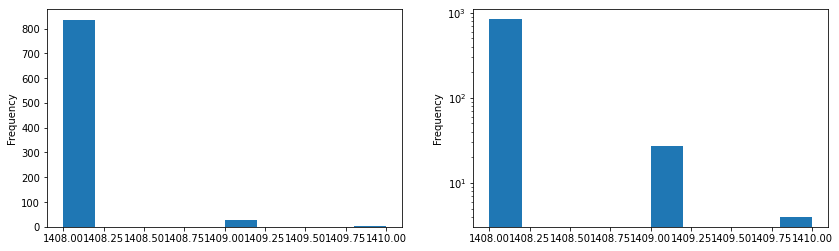

count    11221.000000
mean       182.328402
std        316.095934
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        455.000000
99%       2761.000000
max       2761.000000
Name: fdp_IdUsuarioGestionActual, dtype: float64

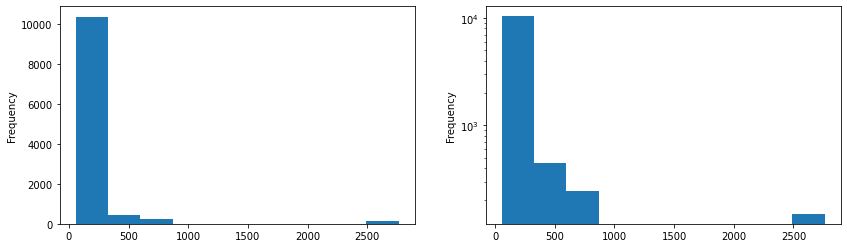

count    1.122100e+04
mean     7.639333e+08
std      4.374684e+08
min      1.386082e+07
5%       5.276967e+07
25%      8.003256e+07
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioGestionActual, dtype: float64

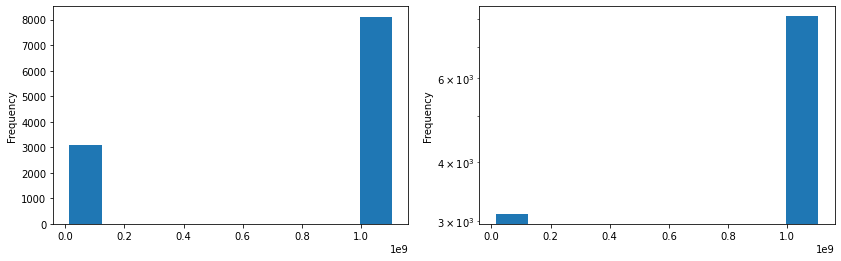

count    11221.000000
mean         7.114963
std          2.170941
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolGestionActual, dtype: float64

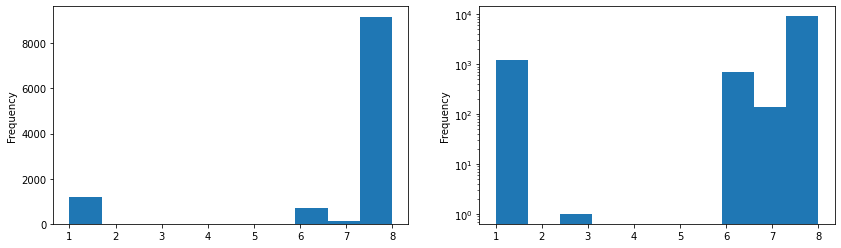

In [60]:


for i in numeros.columns:
  plt.figure(figsize=(14,4))
  display(numeros[i].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99]))
  plt.subplot(1,2,1)
  numeros[i].plot.hist()
  plt.subplot(1,2,2)
  numeros[i].plot.hist()
  plt.yscale('log')
  
  
  plt.show()


In [61]:
niveles =df_Registros_OF[['fgs_Nivel1','fgs_Nivel2','fgs_Nivel3','fgs_Nivel4']].copy()
niveles.head(2)

,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4
0,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit
1,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit


In [62]:
niveles['union']  =  niveles['fgs_Nivel1']+'_*_'+niveles['fgs_Nivel2']+'_*_'+niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()

Cuentas por pagar_*_Recepción y contabilización facturas de proveedores_*_Causación de facturas / Cockpit_*_Causación de facturas / Cockpit                                                                  7939
Cuentas por pagar_*_Recepción y contabilización facturas de proveedores_*_Radicación de facturas_*_Radicación de facturas                                                                                    1457
Cuentas por pagar_*_Recepción y contabilización facturas de proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores    1361
Cuentas por pagar_*_Recepción y contabilización facturas de proveedores_*_Endoso de facturas_*_Endoso de facturas                                                                                             181
Cuentas por pagar_*_Recepción y contabilización facturas de proveedores_*_Retención en Garantía_*_Retención en Garantía                                         

In [63]:
niveles['union']  =niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()

Causación de facturas / Cockpit_*_Causación de facturas / Cockpit                                                                  7939
Radicación de facturas_*_Radicación de facturas                                                                                    1457
Información y Seguimiento a usuarios en página WEB Proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas_*_Endoso de facturas                                                                                             181
Retención en Garantía_*_Retención en Garantía                                                                                       133
Consultas retenciones aplicadas_*_Consultas retenciones aplicadas                                                                   102
Pagos bloqueados_*_Pagos bloqueados                                                                                                  50
Name: union, dtype: int64

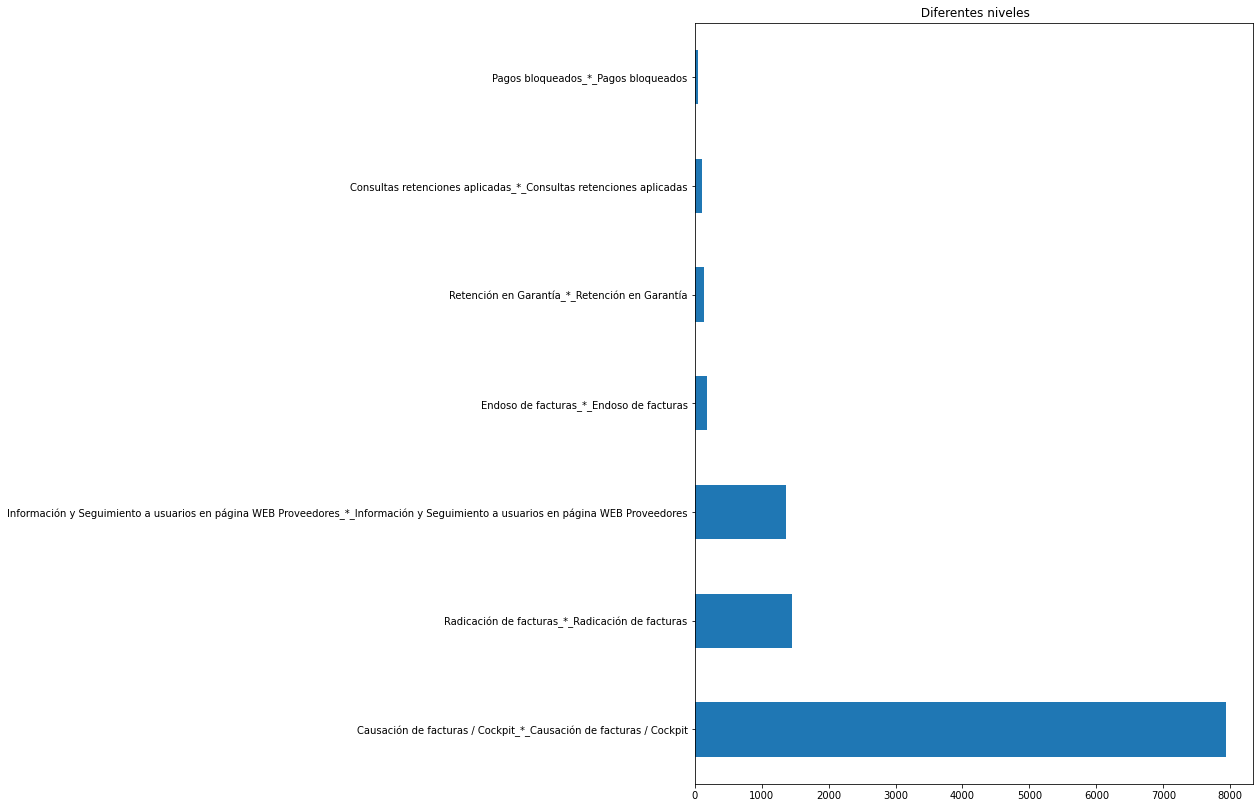

In [90]:

niveles['union'].value_counts().plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [92]:
niveles['fgs_Nivel3'].value_counts()

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel3, dtype: int64

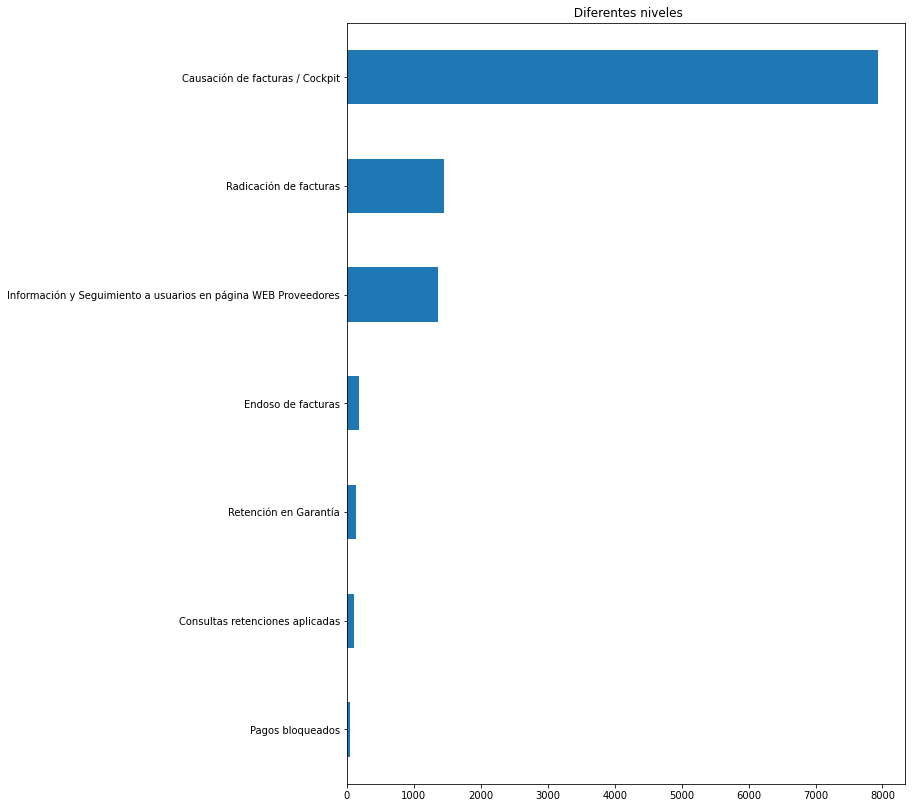

In [94]:
niveles['fgs_Nivel3'].value_counts().sort_values(ascending=True).plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [64]:
# corelacion


In [65]:
objetos.head(2)

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
0,NIT,METROOMAT NDT SAS,172.27.90.93,2021-03-01 06:08:30.000,2021-03-01 06:10:58.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,CR 52 44 A 35,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,xiomara.rodriguez@metroomat.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,nestor.pantano@metroomat.com,Transacciones,Causación de facturas / Cockpit,2021-02-26 11:27:00.000,Cerrado,Nivel1,LAURA MAYERLY BOHORQUEZ GAMBA,Con la presente solicito su colaboración confi...,2021-03-01 06:10:58.000,Asesor de Servicio Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...,2021-03-01 09:45:00.000
1,NIT,CGG SERVICES SUCUSAL COLOMBIA,172.27.90.93,2021-03-01 06:15:54.000,2021-03-01 06:27:09.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,AV CR 45 108 A 50 P 6,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,carlos.chaparro@cgg.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,carlos.chaparro@cgg.com,Puesto de Trabajo,Causación de facturas / Cockpit,2021-02-26 11:43:00.000,Cerrado,Nivel1,JEIMY YOLIMA ARDILA PINZON,"Buenos días, el pasado 21d e enero la empresa ...",2021-03-01 06:27:09.000,Asesor de Servicio BackOffice Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,2021-03-01 06:27:09.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDIL

In [66]:
mapas_nofechas = objetos.columns.str.findall('Fecha').map(lambda x : len(x)==0)# eliminar fecha
objetos_nofechas = objetos[objetos.columns[mapas_nofechas]]

In [67]:
objetos_nofechas.head()

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,GrupoRolGestionActual,fdp_NivelGestionActual,TipoAjuste
0,NIT,METROOMAT NDT SAS,172.27.90.93,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,CR 52 44 A 35,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,xiomara.rodriguez@metroomat.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,nestor.pantano@metroomat.com,Transacciones,Causación de facturas / Cockpit,Cerrado,Nivel1,LAURA MAYERLY BOHORQUEZ GAMBA,Con la presente solicito su colaboración confi...,Asesor de Servicio Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,Asesor de Servicio Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,Asesor de Servicio Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,Asesor de Servicio Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...
1,NIT,CGG SERVICES SUCUSAL COLOMBIA,172.27.90.93,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,AV CR 45 108 A 50 P 6,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,carlos.chaparro@cgg.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,carlos.chaparro@cgg.com,Puesto de Trabajo,Causación de facturas / Cockpit,Cerrado,Nivel1,JEIMY YOLIMA ARDILA PINZON,"Buenos días, el pasado 21d e enero la empresa ...",Asesor de Servicio BackOffice Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,Asesor de Servicio BackOffice Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,Asesor de Servicio BackOffice Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,Asesor de Servicio BackOffice Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...
2,NIT,SANCHO BBDO WORLDWIDE INC SA,172.27.40.50,Atención,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,CL 98 9 03 P 2 BRR CHICO,"BOGOTA, D.C.",BOGOTA,Colombia,2345000,Vanessa.antonio@ecopetrol.com.co,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,karenotalora@sanchobbdo.com,Puesto de Trabajo,Causación de facturas / Cockpit,Escalado,Nivel2,JEIMY NATHALY GOMEZ GOMEZ,Gestion.<br

In [68]:
objetos_nofechas.columns

Index(['fgs_SiglasDocumentoContacto', 'fgs_NombreCompletoContacto', 'fgs_Ip',
       'fgs_Tipificación', 'fgs_Nivel1', 'fgs_Nivel2', 'fgs_Nivel3',
       'fgs_Nivel4', 'fgs_Direccion_01', 'fgs_CiudadDireccion_01',
       'fgs_DepartamentoDireccion_01', 'fgs_PaisDireccion_01',
       'fgs_Telefono_01', 'fgs_Email_01', 'fmf_Canal', 'ude_Regional',
       'ude_CiudadCliente', 'ude_DepartamentoCliente', 'ude_PaisCliente',
       'ude_UnidadOrganizativa', 'ude_CECO', 'ude_CentroDeCostos',
       'ude_EmailCliente', 'SistemaPago', 'ServicioPortafolio',
       'fdp_NombreEstado', 'fdp_NivelEstado', 'fdp_NombreUsuarioCreacion',
       'fgs_ObservacionCreacion', 'GrupoRolCreacion',
       'Cumple_Objetivo_SolicitadoRegistrado',
       'Cumple_Objetivo_RegistradoEscalado', 'fdp_NombreGrupoEscalamientoN2',
       'fdp_NombreUsuarioEscalamientoN2', 'fgs_ObservacionEscalamientoN2',
       'GrupoRolEscalamientoN2', 'Cumple_Objetivo_EnNivel2',
       'fdp_NombreUsuarioDevolucion', 'fgs_ObservacionDev

In [69]:
importa =objetos[['fgs_Nivel3','fgs_ObservacionCreacion','fgs_ObservacionSolucion']]

In [70]:
%%time
importa['fgs_ObservacionCreacion'].str.split().str.len()

CPU times: user 39.5 ms, sys: 17 ms, total: 56.5 ms
Wall time: 59.1 ms


0        34
1        59
2        76
3         3
4         3
         ..
11219    35
11220     8
11221    28
11222     5
11223    13
Name: fgs_ObservacionCreacion, Length: 11223, dtype: int64

In [71]:
%%time
importa['1'] = importa['fgs_ObservacionCreacion'].map(lambda x : len(x.split()))

CPU times: user 26.7 ms, sys: 1.99 ms, total: 28.7 ms
Wall time: 28.6 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
importa['fgs_ObservacionSolucion'].map(lambda x : type(x)).value_counts()

<class 'str'>      10716
<class 'float'>      507
Name: fgs_ObservacionSolucion, dtype: int64

In [73]:
mapa = importa['fgs_ObservacionSolucion'].map(lambda x : type(x))==float

In [74]:
importa[mapa]## no hay solucion por que puede que se le diera solucion directa al cliente. :( )

,fgs_Nivel3,fgs_ObservacionCreacion,fgs_ObservacionSolucion,1
2,Causación de facturas / Cockpit,Gestion.<br>Atendiendo su solicitud le informa...,NaN,76
30,Causación de facturas / Cockpit,GESTIÓN: Su caso se escaló al área encargada p...,NaN,46
66,Causación de facturas / Cockpit,Gestion.<br>Atendiendo su solicitud le informa...,NaN,71
102,Causación de facturas / Cockpit,Su caso se escaló al área encargada para su tr...,NaN,83
147,Causación de facturas / Cockpit,"Buen día, se escala para su amable gestión. Se...",NaN,85
...,...,...,...,...
10620,Causación de facturas / Cockpit,GESTIÓN: Su caso se escaló al área encargada p...,NaN,102
10632,Causación de facturas / Cockpit,Atendiendo su solicitud le informamos que hemo...,NaN,86
10647,Causación de facturas / Cockpit,Su caso se escaló al área encargada para su tr...,NaN,66
10667,Radicación de facturas,Atendiendo su solicitud le informamos que hemo...,NaN,116


In [95]:
importasina = importa.dropna().copy()

In [96]:
importasina['fgs_ObservacionCreacion_cantidad_palabras'] = importasina['fgs_ObservacionCreacion'].map(lambda x : len(x.split())).copy()

In [97]:
importasina['fgs_ObservacionSolucion_cantidad_palabras'] = importasina['fgs_ObservacionSolucion'].copy().map(lambda x : len(x.split()))

In [98]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr()

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.00000,0.10671
fgs_ObservacionSolucion_cantidad_palabras,0.10671,1.00000


In [99]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr(method='spearman')

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.000000,0.210708
fgs_ObservacionSolucion_cantidad_palabras,0.210708,1.000000


In [100]:
# importasina['fgs_ObservacionCreacion_cantidad_palabras'].map(lambda x: x.replace('<br>',' '))

In [101]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))

0        Con la presente solicito su colaboración confi...
1        Buenos días, el pasado 21d e enero la empresa ...
3                                    CONSULTA DE FACTURAS 
4                                    CONSULTA DE FACTURAS 
5               Solicita información de estado de factura 
                               ...                        
11219     Agradecemos su atención y nos permitimos envi...
11220    Srs Ecopetrol solicitó el desbloqueo del usuar...
11221    Amablemente informo que luego de ingresar el n...
11222                   DESBLOQUEO USUARIO PORTAL DE PAGOS
11223    Conforme a las indicaciones brindadas, informa...
Name: fgs_ObservacionCreacion, Length: 10716, dtype: object

In [102]:
importasina['fgs_ObservacionCreacion'][importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]

76       Buen día, se escala para su amable gestión. Se...
79       Buen día, se escala para su amable gestión. Se...
126       Se envía notificación vía correo electrónico<br>
172      ACREEDOR\t3002388<br>NOMBRE\tIMPORTACIONES IND...
185      GESTIÓN: Su caso se escaló al área encargada p...
                               ...                        
10397    Atendiendo su solicitud le informamos que hemo...
10461    Atendiendo su solicitud le informamos que hemo...
10505    GESTIÓN:<br>Atendiendo su solicitud le informa...
10557    Atendiendo su solicitud le informamos que hemo...
10907    le informamos que para poder dar respuesta a s...
Name: fgs_ObservacionCreacion, Length: 393, dtype: object

In [83]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))[importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]

76       Buen día, se escala para su amable gestión. Se...
79       Buen día, se escala para su amable gestión. Se...
126          Se envía notificación vía correo electrónico 
172      ACREEDOR\t3002388 NOMBRE\tIMPORTACIONES INDUST...
185      GESTIÓN: Su caso se escaló al área encargada p...
                               ...                        
10397    Atendiendo su solicitud le informamos que hemo...
10461    Atendiendo su solicitud le informamos que hemo...
10505    GESTIÓN: Atendiendo su solicitud le informamos...
10557    Atendiendo su solicitud le informamos que hemo...
10907    le informamos que para poder dar respuesta a s...
Name: fgs_ObservacionCreacion, Length: 393, dtype: object

In [84]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' ')).value_counts()

CONSULTA DE FACTURAS                                                                                                                                                                                                                                                                                                                                                                                   1036
Solicita información de estado de factura                                                                                                                                                                                                                                                                                                                                                               486
Solicita acceso al portal proveedores                                                                                                                                                                           

In [103]:
importasina['fgs_ObservacionSolucion'].map(lambda x: x.replace('<br>',' ')).value_counts()

Se envía notificación vía correo electrónico                                                                                                                                                                                             426
GESTIÓN: Atendiendo su solicitud le informamos que hemos enviado requerimiento al área encargada para que se verifique este caso y sea solucionado lo más pronto posible.                                                                124
Atendiendo su solicitud le informamos que hemos enviado requerimiento al área encargada para que se verifique este caso y sea solucionado lo más pronto posible.                                                                         100
Se genera correo de respuesta al proveedor, solicitando filtro de seguridad                                                                                                                                                               89
Atendiendo su solicitud le informamos que hemos envi